In [1]:
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error


In [2]:
# Load data
data  = pd.read_pickle('../Data/sales_day.pkl')
data['date'] = pd.to_datetime(data['date'])
data.columns = ['ds', 'y']

In [3]:
# remove outliers
data = data[data['y'] <= data['y'].quantile(0.95)]

In [4]:
# train test split
training_x = data.iloc[:int(len(data)*0.8)]
val_x = data.iloc[int(len(data)*0.8):int(len(data)*0.9)].reset_index(drop=True)
testing_x = data.iloc[int(len(data)*0.9):].reset_index(drop=True)

In [5]:
print(len(training_x))
print(len(val_x))
print(len(testing_x))

458
57
58


In [6]:
m = Prophet(growth='linear', daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative',
            changepoint_prior_scale=0.2,seasonality_prior_scale=5, holidays_prior_scale=5, 
            changepoint_range=0.5, interval_width=0.95, uncertainty_samples=500)
m.add_country_holidays(country_name='UK')
m.fit(training_x)

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81        720.14   0.000413076       22.4192   2.159e-05       0.001      151  LS failed, Hessian reset 
      99       720.148   8.01843e-06       16.4895      0.3948      0.3948      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.255   2.68121e-06       17.5477      0.3007      0.4955      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.278   0.000101979       16.4681           1           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       720.285   8.90032e-05       21.3818           1           1      544   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     406       720.285    2.9678e-06    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [7]:
future = val_x[['ds']]
future.tail()


,ds
52,2011-09-14
53,2011-09-16
54,2011-09-18
55,2011-09-19
56,2011-09-21


In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
52,2011-09-14,19530.251464,5362.561011,30347.439686
53,2011-09-16,19030.347284,5870.512384,30501.295667
54,2011-09-18,17047.961503,4986.727992,28612.710066
55,2011-09-19,24106.942937,11711.403702,36642.494717
56,2011-09-21,25074.510250,13525.615108,36861.327568


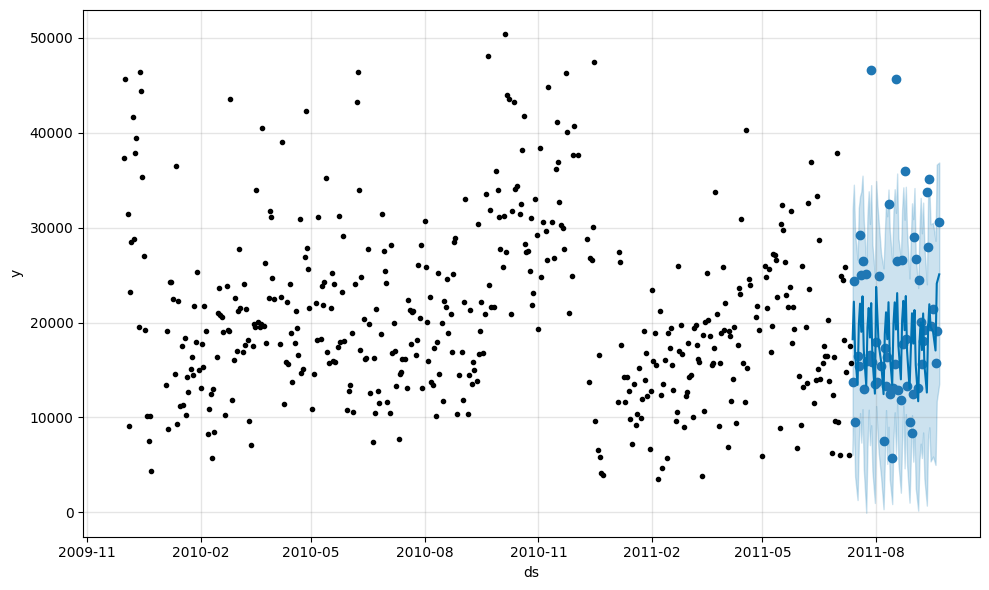

In [9]:
fig1 = m.plot(forecast)
plt.scatter(val_x['ds'], val_x['y'])

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


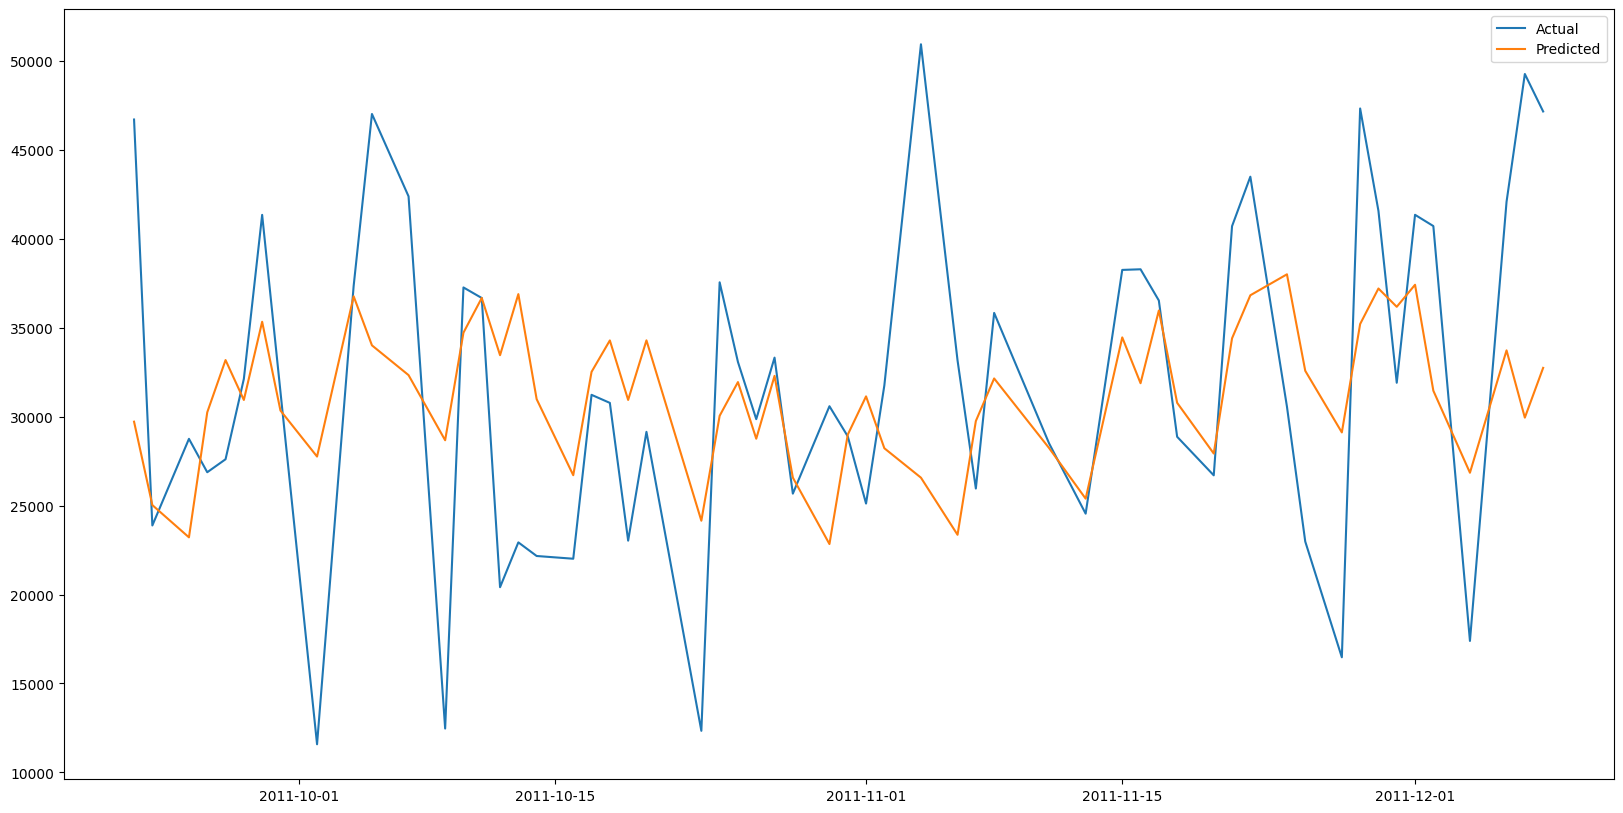

In [10]:
forecast = m.predict(testing_x[['ds']])
plt.figure(figsize=(20,10))
plt.plot(testing_x['ds'], testing_x['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted')
plt.legend()
plt.show()

In [11]:
print("MAPE: ", mean_absolute_percentage_error(testing_x['y'], forecast['yhat']))

MAPE:  0.24704364899050854


In [12]:
def GridProphet(change_prior_scale, seasonality_prior_scale, holidays_prior_scale,changepoint_range, interval_width, uncertainty_samples):
    m = Prophet(growth='linear', daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative',
                changepoint_prior_scale=change_prior_scale, seasonality_prior_scale=seasonality_prior_scale, holidays_prior_scale=holidays_prior_scale,
                changepoint_range=changepoint_range, interval_width=interval_width, uncertainty_samples=uncertainty_samples)
    m.add_country_holidays(country_name='UK')
    m.fit(training_x,verbose=False)
    future = val_x[['ds']]
    forecast = m.predict(future)
    mape = mean_absolute_percentage_error(val_x['y'], forecast['yhat'])
    return mape

In [13]:
from sklearn.model_selection import ParameterGrid
param = {
    'change_prior_scale': [0.05,0.1,0.2], 'seasonality_prior_scale': [4,5,6], 'holidays_prior_scale': [5,6,7],
    'changepoint_range': [0.6,0.7,0.8], 'interval_width': [0.7,0.75,0.8], 'uncertainty_samples': [50,100,150]
         }
param_grid = ParameterGrid(param)

In [14]:
mape = 1
best_param = {}
for p in tqdm(param_grid):
    result = GridProphet(p['change_prior_scale'],p['seasonality_prior_scale'],p['holidays_prior_scale'], p['changepoint_range'], p['interval_width'], p['uncertainty_samples'])
    if result < mape:
        mape = result
        best_param = p
    

  0%|          | 0/729 [00:00<?, ?it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  0%|          | 1/729 [00:00<01:29,  8.14it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.747   0.000320569       78.2632      0.9363      0.9363      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       719.309    1.7532e-05        97.196   2.358e-07       0.001      278  LS failed, Hessian reset 
     199       719.311   7.38588e-06       79.1955      0.8447      0.8447      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.312   5.31376e-08       97.0687      0.2632           1      335   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.747   0.000320569       78.2632      0.9363      0.93

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  0%|          | 3/729 [00:00<01:40,  7.23it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compon

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.038   0.000516041       96.9384      0.3864           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.183   0.000423457       104.714   4.199e-06       0.001      181  LS failed, Hessian reset 
     199        719.31   1.08658e-05       101.713      0.2515      0.8919      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       719.313   3.19281e-07       101.089   3.166e-09       0.001      398  LS failed, Hessian reset 
     277       719.314   2.77013e-08       86.7441      0.5768      0.5768      413   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  1%|          | 6/729 [00:00<01:46,  6.80it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compon

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.038   0.000516041       96.9384      0.3864           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.183   0.000423457       104.714   4.199e-06       0.001      181  LS failed, Hessian reset 
     199        719.31   1.08658e-05       101.713      0.2515      0.8919      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       719.313   3.19281e-07       101.089   3.166e-09       0.001      398  LS failed, Hessian reset 
     277       719.314   2.77013e-08       86.7441      0.5768      0.5768      413   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  1%|          | 8/729 [00:01<01:34,  7.66it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compon

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.942    0.00129504        96.841           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       719.219   0.000544139        101.85   5.929e-06       0.001      188  LS failed, Hessian reset 
     162       719.278   2.98136e-08       87.7874           1           1      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.942    0.00129504        96.841           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       719.219   0.000544139        101.85   5.929e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  1%|▏         | 10/729 [00:01<01:31,  7.82it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.747   0.000320569       78.2632      0.9363      0.9363      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       719.309    1.7532e-05        97.196   2.358e-07       0.001      278  LS failed, Hessian reset 
     199       719.311   7.38588e-06       79.1955      0.8447      0.8447      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.312   5.31376e-08       97.0687      0.2632           1      335   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.747   0.000320569       78.2632      0.9363      0.93

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  2%|▏         | 12/729 [00:01<01:39,  7.19it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.747   0.000320569       78.2632      0.9363      0.9363      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       719.309    1.7532e-05        97.196   2.358e-07       0.001      278  LS failed, Hessian reset 
     199       719.311   7.38588e-06       79.1955      0.8447      0.8447      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.312   5.31376e-08       97.0687      0.2632           1      335   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.038   0.000516041       96.9384      0.3864          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  2%|▏         | 13/729 [00:01<01:37,  7.35it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.038   0.000516041       96.9384      0.3864           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.183   0.000423457       104.714   4.199e-06       0.001      181  LS failed, Hessian reset 
     199        719.31   1.08658e-05       101.713      0.2515      0.8919      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       719.313   3.19281e-07       101.089   3.166e-09       0.001      398  LS failed, Hessian reset 
     277       719.314   2.77013e-08       86.7441      0.5768      0.5768      413   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  2%|▏         | 15/729 [00:02<01:42,  6.93it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.942    0.00129504        96.841           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       719.219   0.000544139        101.85   5.929e-06       0.001      188  LS failed, Hessian reset 
     162       719.278   2.98136e-08       87.7874           1           1      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.942    0.00129504        96.841           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       719.219   0.000544139        101.85   5.929e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  2%|▏         | 18/729 [00:02<01:31,  7.78it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.747   0.000320569       78.2632      0.9363      0.9363      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       719.309    1.7532e-05        97.196   2.358e-07       0.001      278  LS failed, Hessian reset 
     199       719.311   7.38588e-06       79.1955      0.8447      0.8447      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.312   5.31376e-08       97.0687      0.2632           1      335   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.747   0.000320569       78.2632      0.9363      0.93

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  3%|▎         | 21/729 [00:02<01:33,  7.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.747   0.000320569       78.2632      0.9363      0.9363      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       719.309    1.7532e-05        97.196   2.358e-07       0.001      278  LS failed, Hessian reset 
     199       719.311   7.38588e-06       79.1955      0.8447      0.8447      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.312   5.31376e-08       97.0687      0.2632           1      335   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.038   0.000516041       96.9384      0.3864          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  3%|▎         | 23/729 [00:03<01:34,  7.50it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.038   0.000516041       96.9384      0.3864           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.183   0.000423457       104.714   4.199e-06       0.001      181  LS failed, Hessian reset 
     199        719.31   1.08658e-05       101.713      0.2515      0.8919      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       719.313   3.19281e-07       101.089   3.166e-09       0.001      398  LS failed, Hessian reset 
     277       719.314   2.77013e-08       86.7441      0.5768      0.5768      413   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  3%|▎         | 25/729 [00:03<01:30,  7.75it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.942    0.00129504        96.841           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       719.219   0.000544139        101.85   5.929e-06       0.001      188  LS failed, Hessian reset 
     162       719.278   2.98136e-08       87.7874           1           1      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.942    0.00129504        96.841           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       719.219   0.000544139        101.85   5.929e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  4%|▎         | 27/729 [00:03<01:30,  7.80it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       718.575     0.0020139       108.835   2.508e-05       0.001      132  LS failed, Hessian reset 
      99       718.745   2.81907e-05       83.6929      0.4505      0.4505      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.133    0.00304911       102.914   3.041e-05       0.001      235  LS failed, Hessian reset 
     199       719.336   1.29189e-06       90.2653           1           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.366   3.88264e-07       98.8085      0.2855       0.934      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       719.367   3.29355e-08       86.5216      0.3597      0.9163      447   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  4%|▍         | 30/729 [00:04<01:38,  7.08it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       718.575     0.0020139       108.835   2.508e-05       0.001      132  LS failed, Hessian reset 
      99       718.745   2.81907e-05       83.6929      0.4505      0.4505      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.133    0.00304911       102.914   3.041e-05       0.001      235  LS failed, Hessian reset 
     199       719.336   1.29189e-06       90.2653           1           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.366   3.88264e-07       98.8085      0.2855       0.934      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       719.367   3.29355e-08       86.5216      0.3597      0.9163      447   
Optimization terminated normally: 
  Convergence detected: rel

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  4%|▍         | 32/729 [00:04<01:29,  7.75it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.815    0.00010047       79.3538       0.333           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.094    0.00165418       106.409   2.013e-05       0.001      198  LS failed, Hessian reset 
     195       719.226   3.68891e-08       96.6999      0.3397           1      294   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.986   0.000248094       75.0978      0.9373      0.9373      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.201   0.000503491       102.542   5.134e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  5%|▍         | 35/729 [00:04<01:31,  7.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.986   0.000248094       75.0978      0.9373      0.9373      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.201   0.000503491       102.542   5.134e-06       0.001      197  LS failed, Hessian reset 
     194       719.297   9.37389e-06       89.0249   9.258e-08       0.001      324  LS failed, Hessian reset 
     199       719.298     2.616e-06       93.0445      0.4089      0.9995      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       719.298   6.06454e-08       86.9553       0.968       0.968      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  5%|▍         | 36/729 [00:04<01:35,  7.23it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       718.575     0.0020139       108.835   2.508e-05       0.001      132  LS failed, Hessian reset 
      99       718.745   2.81907e-05       83.6929      0.4505      0.4505      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.133    0.00304911       102.914   3.041e-05       0.001      235  LS failed, Hessian reset 
     199       719.336   1.29189e-06       90.2653           1           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.366   3.88264e-07       98.8085      0.2855       0.934      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       719.367   3.29355e-08       86.5216      0.3597      0.9163      447   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  5%|▌         | 39/729 [00:05<01:40,  6.84it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       718.575     0.0020139       108.835   2.508e-05       0.001      132  LS failed, Hessian reset 
      99       718.745   2.81907e-05       83.6929      0.4505      0.4505      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.133    0.00304911       102.914   3.041e-05       0.001      235  LS failed, Hessian reset 
     199       719.336   1.29189e-06       90.2653           1           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.366   3.88264e-07       98.8085      0.2855       0.934      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       719.367   3.29355e-08       86.5216      0.3597      0.9163      447   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  6%|▌         | 41/729 [00:05<01:30,  7.61it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.815    0.00010047       79.3538       0.333           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.094    0.00165418       106.409   2.013e-05       0.001      198  LS failed, Hessian reset 
     195       719.226   3.68891e-08       96.6999      0.3397           1      294   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.815    0.00010047       79.3538       0.333           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.094    0.00165418       106.409   2.013e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  6%|▌         | 43/729 [00:05<01:37,  7.04it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.986   0.000248094       75.0978      0.9373      0.9373      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.201   0.000503491       102.542   5.134e-06       0.001      197  LS failed, Hessian reset 
     194       719.297   9.37389e-06       89.0249   9.258e-08       0.001      324  LS failed, Hessian reset 
     199       719.298     2.616e-06       93.0445      0.4089      0.9995      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       719.298   6.06454e-08       86.9553       0.968       0.968      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  6%|▌         | 44/729 [00:05<01:35,  7.14it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.986   0.000248094       75.0978      0.9373      0.9373      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.201   0.000503491       102.542   5.134e-06       0.001      197  LS failed, Hessian reset 
     194       719.297   9.37389e-06       89.0249   9.258e-08       0.001      324  LS failed, Hessian reset 
     199       719.298     2.616e-06       93.0445      0.4089      0.9995      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       719.298   6.06454e-08       86.9553       0.968       0.968      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  6%|▋         | 47/729 [00:06<01:36,  7.10it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       718.575     0.0020139       108.835   2.508e-05       0.001      132  LS failed, Hessian reset 
      99       718.745   2.81907e-05       83.6929      0.4505      0.4505      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.133    0.00304911       102.914   3.041e-05       0.001      235  LS failed, Hessian reset 
     199       719.336   1.29189e-06       90.2653           1           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.366   3.88264e-07       98.8085      0.2855       0.934      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       719.367   3.29355e-08       86.5216      0.3597      0.9163      447   
Optimization terminated normally: 
  Convergence detected: rel

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  7%|▋         | 48/729 [00:06<01:41,  6.73it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.815    0.00010047       79.3538       0.333           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.094    0.00165418       106.409   2.013e-05       0.001      198  LS failed, Hessian reset 
     195       719.226   3.68891e-08       96.6999      0.3397           1      294   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.815    0.00010047       79.3538       0.333           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.094    0.00165418       106.409   2.013e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  7%|▋         | 51/729 [00:06<01:31,  7.42it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.986   0.000248094       75.0978      0.9373      0.9373      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.201   0.000503491       102.542   5.134e-06       0.001      197  LS failed, Hessian reset 
     194       719.297   9.37389e-06       89.0249   9.258e-08       0.001      324  LS failed, Hessian reset 
     199       719.298     2.616e-06       93.0445      0.4089      0.9995      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       719.298   6.06454e-08       86.9553       0.968       0.968      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  7%|▋         | 54/729 [00:07<01:34,  7.15it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.986   0.000248094       75.0978      0.9373      0.9373      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       719.201   0.000503491       102.542   5.134e-06       0.001      197  LS failed, Hessian reset 
     194       719.297   9.37389e-06       89.0249   9.258e-08       0.001      324  LS failed, Hessian reset 
     199       719.298     2.616e-06       93.0445      0.4089      0.9995      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       719.298   6.06454e-08       86.9553       0.968       0.968      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

  8%|▊         | 55/729 [00:07<01:33,  7.18it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  8%|▊         | 56/729 [00:07<01:36,  6.95it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84        718.62    0.00111933       79.2203    1.31e-05       0.001      136  LS failed, Hessian reset 
      99       718.728   0.000164438       97.3648      0.3348           1      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       719.149    0.00072591       102.425   6.855e-06       0.001      266  LS failed, Hessian reset 
     199       719.295    0.00329823       97.1487           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       719.361   3.05921e-05        84.758   3.791e-07       0.001      469  LS failed, Hessian reset 
     299       719.366   4.31152e-05       78.0872           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  8%|▊         | 57/729 [00:07<01:42,  6.56it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.976    0.00180544       98.3463      0.5439      0.5439      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.262   2.91615e-08       97.4687      0.6812      0.6812      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       719.262   3.17675e-08       89.0143       0.208           1      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.976    0.00180544       98.3463      0.5439      0.5439      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  8%|▊         | 60/729 [00:08<01:29,  7.50it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.976    0.00180544       98.3463      0.5439      0.5439      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.262   2.91615e-08       97.4687      0.6812      0.6812      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       719.262   3.17675e-08       89.0143       0.208           1      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.803   9.03932e-05       83.7412       0.199      0.6937      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  9%|▊         | 62/729 [00:08<01:31,  7.30it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.803   9.03932e-05       83.7412       0.199      0.6937      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       718.912    0.00102357        96.538   1.407e-05       0.001      173  LS failed, Hessian reset 
     199       719.062   0.000489999       76.4386      0.6161      0.6161      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.378   1.91575e-07        83.174      0.3557      0.3557      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       719.378   6.81584e-09         84.61      0.1729      0.1729      466   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probabili

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  9%|▊         | 63/729 [00:08<01:35,  6.95it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84        718.62    0.00111933       79.2203    1.31e-05       0.001      136  LS failed, Hessian reset 
      99       718.728   0.000164438       97.3648      0.3348           1      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       719.149    0.00072591       102.425   6.855e-06       0.001      266  LS failed, Hessian reset 
     199       719.295    0.00329823       97.1487           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       719.361   3.05921e-05        84.758   3.791e-07       0.001      469  LS failed, Hessian reset 
     299       719.366   4.31152e-05       78.0872           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  9%|▉         | 66/729 [00:09<01:43,  6.39it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84        718.62    0.00111933       79.2203    1.31e-05       0.001      136  LS failed, Hessian reset 
      99       718.728   0.000164438       97.3648      0.3348           1      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       719.149    0.00072591       102.425   6.855e-06       0.001      266  LS failed, Hessian reset 
     199       719.295    0.00329823       97.1487           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       719.361   3.05921e-05        84.758   3.791e-07       0.001      469  LS failed, Hessian reset 
     299       719.366   4.31152e-05       78.0872           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
  9%|▉         | 68/729 [00:09<01:28,  7.49it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.976    0.00180544       98.3463      0.5439      0.5439      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.262   2.91615e-08       97.4687      0.6812      0.6812      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       719.262   3.17675e-08       89.0143       0.208           1      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.803   9.03932e-05       83.7412       0.199      0.6937      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 10%|▉         | 70/729 [00:09<01:27,  7.56it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.803   9.03932e-05       83.7412       0.199      0.6937      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       718.912    0.00102357        96.538   1.407e-05       0.001      173  LS failed, Hessian reset 
     199       719.062   0.000489999       76.4386      0.6161      0.6161      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.378   1.91575e-07        83.174      0.3557      0.3557      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       719.378   6.81584e-09         84.61      0.1729      0.1729      466   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probabili

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 10%|▉         | 72/729 [00:09<01:34,  6.92it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84        718.62    0.00111933       79.2203    1.31e-05       0.001      136  LS failed, Hessian reset 
      99       718.728   0.000164438       97.3648      0.3348           1      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       719.149    0.00072591       102.425   6.855e-06       0.001      266  LS failed, Hessian reset 
     199       719.295    0.00329823       97.1487           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       719.361   3.05921e-05        84.758   3.791e-07       0.001      469  LS failed, Hessian reset 
     299       719.366   4.31152e-05       78.0872           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 10%|█         | 75/729 [00:10<01:41,  6.42it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84        718.62    0.00111933       79.2203    1.31e-05       0.001      136  LS failed, Hessian reset 
      99       718.728   0.000164438       97.3648      0.3348           1      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       719.149    0.00072591       102.425   6.855e-06       0.001      266  LS failed, Hessian reset 
     199       719.295    0.00329823       97.1487           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       719.361   3.05921e-05        84.758   3.791e-07       0.001      469  LS failed, Hessian reset 
     299       719.366   4.31152e-05       78.0872           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 11%|█         | 77/729 [00:10<01:26,  7.51it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.976    0.00180544       98.3463      0.5439      0.5439      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.262   2.91615e-08       97.4687      0.6812      0.6812      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       719.262   3.17675e-08       89.0143       0.208           1      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.803   9.03932e-05       83.7412       0.199      0.6937      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 11%|█         | 79/729 [00:10<01:27,  7.42it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.803   9.03932e-05       83.7412       0.199      0.6937      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       718.912    0.00102357        96.538   1.407e-05       0.001      173  LS failed, Hessian reset 
     199       719.062   0.000489999       76.4386      0.6161      0.6161      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.378   1.91575e-07        83.174      0.3557      0.3557      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       719.378   6.81584e-09         84.61      0.1729      0.1729      466   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probabili

 11%|█         | 81/729 [00:11<01:34,  6.83it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.179    0.00176648       85.0217           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       719.239   2.61563e-05        98.634   2.611e-07       0.001      199  LS failed, Hessian reset 
     159       719.241   3.01073e-08       86.2658      0.3134      0.9952      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.179    0.00176648       85.0217           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       719.239   2.61563e-05        98.634   2.611e-07       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 12%|█▏        | 84/729 [00:11<01:23,  7.72it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.179    0.00176648       85.0217           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       719.239   2.61563e-05        98.634   2.611e-07       0.001      199  LS failed, Hessian reset 
     159       719.241   3.01073e-08       86.2658      0.3134      0.9952      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.109   0.000171157       104.339      0.5251      0.5251      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.263   0.000100277       92.5368           1           1      240   
    Iter      log prob    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 12%|█▏        | 86/729 [00:11<01:23,  7.69it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.109   0.000171157       104.339      0.5251      0.5251      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.263   0.000100277       92.5368           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       719.295   6.08406e-08       90.1128      0.8814      0.8814      355   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.215   1.51914e-05       80.2073      0.3585      0.3585      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 12%|█▏        | 89/729 [00:12<01:17,  8.21it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.215   1.51914e-05       80.2073      0.3585      0.3585      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.223   2.14187e-08       76.8267     0.08406      0.3224      228   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.215   1.51914e-05       80.2073      0.3585      0.3585      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.223   2.14187e-08       76.8267     0.08406      0.3224      228   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 12%|█▏        | 91/729 [00:12<01:15,  8.51it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.179    0.00176648       85.0217           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       719.239   2.61563e-05        98.634   2.611e-07       0.001      199  LS failed, Hessian reset 
     159       719.241   3.01073e-08       86.2658      0.3134      0.9952      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.179    0.00176648       85.0217           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       719.239   2.61563e-05        98.634   2.611e-07       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 13%|█▎        | 93/729 [00:12<01:18,  8.08it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.109   0.000171157       104.339      0.5251      0.5251      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.263   0.000100277       92.5368           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       719.295   6.08406e-08       90.1128      0.8814      0.8814      355   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.109   0.000171157       104.339      0.5251      0.5251      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 13%|█▎        | 96/729 [00:12<01:23,  7.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.109   0.000171157       104.339      0.5251      0.5251      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.263   0.000100277       92.5368           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       719.295   6.08406e-08       90.1128      0.8814      0.8814      355   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.215   1.51914e-05       80.2073      0.3585      0.3585      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.223   2.14187e-08       76

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 13%|█▎        | 98/729 [00:13<01:15,  8.33it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compo

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.215   1.51914e-05       80.2073      0.3585      0.3585      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.223   2.14187e-08       76.8267     0.08406      0.3224      228   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.179    0.00176648       85.0217           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       719.239   2.61563e-05        98.634   2.611e-07       0.001      199  LS failed, Hessian reset 
     159       719.241   3.01073e-08       86.2658      0.3134      0.99

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 14%|█▍        | 101/729 [00:13<01:16,  8.16it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.179    0.00176648       85.0217           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       719.239   2.61563e-05        98.634   2.611e-07       0.001      199  LS failed, Hessian reset 
     159       719.241   3.01073e-08       86.2658      0.3134      0.9952      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.109   0.000171157       104.339      0.5251      0.5251      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.263   0.000100277       92.5368           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 14%|█▍        | 104/729 [00:13<01:19,  7.91it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.109   0.000171157       104.339      0.5251      0.5251      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.263   0.000100277       92.5368           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       719.295   6.08406e-08       90.1128      0.8814      0.8814      355   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.109   0.000171157       104.339      0.5251      0.5251      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.263   0.000100277       92

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 15%|█▍        | 106/729 [00:14<01:17,  8.02it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.215   1.51914e-05       80.2073      0.3585      0.3585      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.223   2.14187e-08       76.8267     0.08406      0.3224      228   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.215   1.51914e-05       80.2073      0.3585      0.3585      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.223   2.14187e-08       76.8267     0.08406      0.3224      228   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 15%|█▍        | 108/729 [00:14<01:16,  8.11it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.215   1.51914e-05       80.2073      0.3585      0.3585      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.223   2.14187e-08       76.8267     0.08406      0.3224      228   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        719.24   0.000368993       93.4686   3.966e-06       0.001      180  LS failed, Hessian reset 
     179       719.274    9.9147e-07       91.0439   1.119e-08       0.001      287  LS failed, Hessian reset 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 15%|█▌        | 110/729 [00:14<01:15,  8.20it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        719.24   0.000368993       93.4686   3.966e-06       0.001      180  LS failed, Hessian reset 
     179       719.274    9.9147e-07       91.0439   1.119e-08       0.001      287  LS failed, Hessian reset 
     193       719.274   2.65144e-08       79.0487           1           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 15%|█▌        | 112/729 [00:14<01:17,  7.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.129   0.000156855       90.8835   1.554e-06       0.001      192  LS failed, Hessian reset 
     174       719.141   1.03943e-06        79.482   1.228e-08       0.001      309  LS failed, Hessian reset 
     192       719.141   7.44667e-09       75.4278      0.1925      0.1925      333   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 16%|█▌        | 114/729 [00:15<01:21,  7.57it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.215   0.000354517       104.812   3.599e-06       0.001      162  LS failed, Hessian reset 
     166       719.231   2.82399e-08       90.0731      0.4786           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.215   0.000354517       104.812   3.599e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 16%|█▌        | 117/729 [00:15<01:14,  8.17it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        719.24   0.000368993       93.4686   3.966e-06       0.001      180  LS failed, Hessian reset 
     179       719.274    9.9147e-07       91.0439   1.119e-08       0.001      287  LS failed, Hessian reset 
     193       719.274   2.65144e-08       79.0487           1           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 16%|█▋        | 120/729 [00:15<01:17,  7.86it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        719.24   0.000368993       93.4686   3.966e-06       0.001      180  LS failed, Hessian reset 
     179       719.274    9.9147e-07       91.0439   1.119e-08       0.001      287  LS failed, Hessian reset 
     193       719.274   2.65144e-08       79.0487           1           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 17%|█▋        | 122/729 [00:16<01:15,  8.07it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.129   0.000156855       90.8835   1.554e-06       0.001      192  LS failed, Hessian reset 
     174       719.141   1.03943e-06        79.482   1.228e-08       0.001      309  LS failed, Hessian reset 
     192       719.141   7.44667e-09       75.4278      0.1925      0.1925      333   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 17%|█▋        | 125/729 [00:16<01:11,  8.42it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.215   0.000354517       104.812   3.599e-06       0.001      162  LS failed, Hessian reset 
     166       719.231   2.82399e-08       90.0731      0.4786           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.215   0.000354517       104.812   3.599e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 17%|█▋        | 127/729 [00:16<01:11,  8.39it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        719.24   0.000368993       93.4686   3.966e-06       0.001      180  LS failed, Hessian reset 
     179       719.274    9.9147e-07       91.0439   1.119e-08       0.001      287  LS failed, Hessian reset 
     193       719.274   2.65144e-08       79.0487           1           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 18%|█▊        | 129/729 [00:17<01:15,  7.90it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.145   0.000181298       68.0967           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        719.24   0.000368993       93.4686   3.966e-06       0.001      180  LS failed, Hessian reset 
     179       719.274    9.9147e-07       91.0439   1.119e-08       0.001      287  LS failed, Hessian reset 
     193       719.274   2.65144e-08       79.0487           1           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 18%|█▊        | 131/729 [00:17<01:14,  8.04it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.129   0.000156855       90.8835   1.554e-06       0.001      192  LS failed, Hessian reset 
     174       719.141   1.03943e-06        79.482   1.228e-08       0.001      309  LS failed, Hessian reset 
     192       719.141   7.44667e-09       75.4278      0.1925      0.1925      333   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||    

 18%|█▊        | 132/729 [00:17<01:18,  7.64it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 18%|█▊        | 133/729 [00:17<01:13,  8.07it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.215   0.000354517       104.812   3.599e-06       0.001      162  LS failed, Hessian reset 
     166       719.231   2.82399e-08       90.0731      0.4786           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.199    0.00012191       101.777           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       719.215   0.000354517       104.812   3.599e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 19%|█▊        | 135/729 [00:17<01:13,  8.11it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         719.2   0.000450349       86.3965      0.7047      0.7047      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       719.254   0.000192545       102.635   2.259e-06       0.001      182  LS failed, Hessian reset 
     143       719.272   1.76498e-05       99.1843   1.933e-07       0.001      269  LS failed, Hessian reset 
     178       719.275   3.08243e-08       88.3308      0.9061      0.9061      311   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         719.2   0.000450349       86.3965      0.7047      0.7047      125   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 19%|█▉        | 138/729 [00:18<01:14,  7.94it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.076   0.000326173       86.7775           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       719.086   0.000152533       90.9125   1.623e-06       0.001      166  LS failed, Hessian reset 
     199       719.156   6.37123e-07       87.7436      0.7476      0.7476      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        719.21   3.35998e-05       103.643      0.8634      0.8634      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     381        719.29   2.47987e-07       101.522   2.361e-09       0.001      551  LS failed, Hessian reset 
     386        719.29    1.0767e-08       85.2991     0.05264           1      559   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 19%|█▉        | 141/729 [00:18<01:28,  6.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.076   0.000326173       86.7775           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       719.086   0.000152533       90.9125   1.623e-06       0.001      166  LS failed, Hessian reset 
     199       719.156   6.37123e-07       87.7436      0.7476      0.7476      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        719.21   3.35998e-05       103.643      0.8634      0.8634      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     381        719.29   2.47987e-07       101.522   2.361e-09       0.001      551  LS failed, Hessian reset 
     386        719.29    1.0767e-08       85.2991     0.05264           1      559   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 20%|█▉        | 143/729 [00:18<01:16,  7.66it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.217   3.72504e-05       80.5114       0.512       0.512      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       719.233   9.53461e-05       85.4526   9.812e-07       0.001      185  LS failed, Hessian reset 
     178        719.24   2.58844e-08       86.9719      0.3579      0.3579      265   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         719.2   0.000450349       86.3965      0.7047      0.7047      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       719.254   0.000192545       102.635   2.259e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 20%|██        | 146/729 [00:19<01:12,  8.03it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         719.2   0.000450349       86.3965      0.7047      0.7047      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       719.254   0.000192545       102.635   2.259e-06       0.001      182  LS failed, Hessian reset 
     143       719.272   1.76498e-05       99.1843   1.933e-07       0.001      269  LS failed, Hessian reset 
     178       719.275   3.08243e-08       88.3308      0.9061      0.9061      311   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         719.2   0.000450349       86.3965      0.7047      0.7047      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 20%|██        | 148/729 [00:19<01:17,  7.45it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.076   0.000326173       86.7775           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       719.086   0.000152533       90.9125   1.623e-06       0.001      166  LS failed, Hessian reset 
     199       719.156   6.37123e-07       87.7436      0.7476      0.7476      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        719.21   3.35998e-05       103.643      0.8634      0.8634      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     381        719.29   2.47987e-07       101.522   2.361e-09       0.001      551  LS failed, Hessian reset 
     386        719.29    1.0767e-08       85.2991     0.05264           1      559   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 21%|██        | 150/729 [00:19<01:27,  6.58it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.076   0.000326173       86.7775           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       719.086   0.000152533       90.9125   1.623e-06       0.001      166  LS failed, Hessian reset 
     199       719.156   6.37123e-07       87.7436      0.7476      0.7476      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        719.21   3.35998e-05       103.643      0.8634      0.8634      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     381        719.29   2.47987e-07       101.522   2.361e-09       0.001      551  LS failed, Hessian reset 
     386        719.29    1.0767e-08       85.2991     0.05264           1      559   
Optimization terminated normally: 
  Convergence detected: rel

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 21%|██        | 152/729 [00:20<01:16,  7.57it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.217   3.72504e-05       80.5114       0.512       0.512      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       719.233   9.53461e-05       85.4526   9.812e-07       0.001      185  LS failed, Hessian reset 
     178        719.24   2.58844e-08       86.9719      0.3579      0.3579      265   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         719.2   0.000450349       86.3965      0.7047      0.7047      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       719.254   0.000192545       102.635   2.259e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 21%|██        | 154/729 [00:20<01:16,  7.47it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         719.2   0.000450349       86.3965      0.7047      0.7047      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       719.254   0.000192545       102.635   2.259e-06       0.001      182  LS failed, Hessian reset 
     143       719.272   1.76498e-05       99.1843   1.933e-07       0.001      269  LS failed, Hessian reset 
     178       719.275   3.08243e-08       88.3308      0.9061      0.9061      311   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         719.2   0.000450349       86.3965      0.7047      0.7047      125   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 22%|██▏       | 157/729 [00:20<01:17,  7.34it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.076   0.000326173       86.7775           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       719.086   0.000152533       90.9125   1.623e-06       0.001      166  LS failed, Hessian reset 
     199       719.156   6.37123e-07       87.7436      0.7476      0.7476      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        719.21   3.35998e-05       103.643      0.8634      0.8634      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     381        719.29   2.47987e-07       101.522   2.361e-09       0.001      551  LS failed, Hessian reset 
     386        719.29    1.0767e-08       85.2991     0.05264           1      559   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 22%|██▏       | 159/729 [00:21<01:25,  6.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.076   0.000326173       86.7775           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       719.086   0.000152533       90.9125   1.623e-06       0.001      166  LS failed, Hessian reset 
     199       719.156   6.37123e-07       87.7436      0.7476      0.7476      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        719.21   3.35998e-05       103.643      0.8634      0.8634      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     381        719.29   2.47987e-07       101.522   2.361e-09       0.001      551  LS failed, Hessian reset 
     386        719.29    1.0767e-08       85.2991     0.05264           1      559   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 22%|██▏       | 161/729 [00:21<01:14,  7.62it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.217   3.72504e-05       80.5114       0.512       0.512      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       719.233   9.53461e-05       85.4526   9.812e-07       0.001      185  LS failed, Hessian reset 
     178        719.24   2.58844e-08       86.9719      0.3579      0.3579      265   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.14    0.00043187       83.4134           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       719.168   5.62584e-07       94.7063   6.085e-09       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 22%|██▏       | 164/729 [00:21<01:08,  8.22it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.14    0.00043187       83.4134           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       719.168   5.62584e-07       94.7063   6.085e-09       0.001      246  LS failed, Hessian reset 
     171       719.168   6.58898e-09       105.615      0.2877      0.2877      265   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.001   2.03129e-05       65.7363      0.2796      0.7504      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.187   7.26771e-07       100.656      0.3394           

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 23%|██▎       | 167/729 [00:22<01:10,  7.95it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.001   2.03129e-05       65.7363      0.2796      0.7504      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.187   7.26771e-07       100.656      0.3394           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       719.189   9.02861e-06       98.1734   7.655e-08       0.001      320  LS failed, Hessian reset 
     246       719.189    1.5102e-08       87.7743      0.2534       0.761      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.001   2.03129e-05       65.7363      0.2796      0.75

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebre

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.007   0.000397218       74.3728      0.2389           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       719.126   4.22203e-09       87.5566      0.1573      0.1573      211   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.007   0.000397218       74.3728      0.2389           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       719.126   4.22203e-09       87.5566      0.1573      0.1573      211   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below to

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 23%|██▎       | 171/729 [00:22<01:09,  8.06it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.007   0.000397218       74.3728      0.2389           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       719.126   4.22203e-09       87.5566      0.1573      0.1573      211   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.14    0.00043187       83.4134           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       719.168   5.62584e-07       94.7063   6.085e-09       0.001      246  LS failed, Hessian reset 
     171       719.168   6.58898e-09       105.615      0.2877      0.2877      265   
Optimization terminated nor

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 24%|██▎       | 173/729 [00:22<01:05,  8.45it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.14    0.00043187       83.4134           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       719.168   5.62584e-07       94.7063   6.085e-09       0.001      246  LS failed, Hessian reset 
     171       719.168   6.58898e-09       105.615      0.2877      0.2877      265   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.14    0.00043187       83.4134           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       719.168   5.62584e-07       94.7063   6.085e-09       0.001      246  LS failed, Hessian reset 
   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 24%|██▍       | 175/729 [00:22<01:07,  8.25it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.001   2.03129e-05       65.7363      0.2796      0.7504      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.187   7.26771e-07       100.656      0.3394           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       719.189   9.02861e-06       98.1734   7.655e-08       0.001      320  LS failed, Hessian reset 
     246       719.189    1.5102e-08       87.7743      0.2534       0.761      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.001   2.03129e-05       65.7363      0.2796      0.75

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 24%|██▍       | 177/729 [00:23<01:13,  7.51it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.001   2.03129e-05       65.7363      0.2796      0.7504      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.187   7.26771e-07       100.656      0.3394           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       719.189   9.02861e-06       98.1734   7.655e-08       0.001      320  LS failed, Hessian reset 
     246       719.189    1.5102e-08       87.7743      0.2534       0.761      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.007   0.000397218       74.3728      0.2389           1      128   
    Iter      log prob    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 25%|██▍       | 179/729 [00:23<01:05,  8.37it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.007   0.000397218       74.3728      0.2389           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       719.126   4.22203e-09       87.5566      0.1573      0.1573      211   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.007   0.000397218       74.3728      0.2389           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       719.126   4.22203e-09       87.5566      0.1573      0.1573      211   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 25%|██▍       | 181/729 [00:23<01:03,  8.65it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.14    0.00043187       83.4134           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       719.168   5.62584e-07       94.7063   6.085e-09       0.001      246  LS failed, Hessian reset 
     171       719.168   6.58898e-09       105.615      0.2877      0.2877      265   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.14    0.00043187       83.4134           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       719.168   5.62584e-07       94.7063   6.085e-09       0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 25%|██▌       | 184/729 [00:24<01:04,  8.44it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.001   2.03129e-05       65.7363      0.2796      0.7504      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.187   7.26771e-07       100.656      0.3394           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       719.189   9.02861e-06       98.1734   7.655e-08       0.001      320  LS failed, Hessian reset 
     246       719.189    1.5102e-08       87.7743      0.2534       0.761      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.001   2.03129e-05       65.7363      0.2796      0.7504      133   
    Iter      log prob    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 26%|██▌       | 186/729 [00:24<01:10,  7.65it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.001   2.03129e-05       65.7363      0.2796      0.7504      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.187   7.26771e-07       100.656      0.3394           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       719.189   9.02861e-06       98.1734   7.655e-08       0.001      320  LS failed, Hessian reset 
     246       719.189    1.5102e-08       87.7743      0.2534       0.761      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.007   0.000397218       74.3728      0.2389          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 26%|██▌       | 188/729 [00:24<01:03,  8.47it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.007   0.000397218       74.3728      0.2389           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       719.126   4.22203e-09       87.5566      0.1573      0.1573      211   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.188   2.59307e-05       100.929      0.7341      0.7341      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 26%|██▌       | 191/729 [00:24<01:04,  8.28it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.188   2.59307e-05       100.929      0.7341      0.7341      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       719.194   3.05119e-08       76.4023      0.6043      0.6043      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 26%|██▋       | 193/729 [00:25<01:09,  7.77it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

olute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.032   0.000132226       89.1793   1.391e-06       0.001      161  LS failed, Hessian reset 
      99       719.034   5.06893e-05       67.4271      0.9199      0.9199      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.051   5.89594e-05       67.3998   7.391e-07       0.001      250  LS failed, Hessian reset 
     199        719.06   1.56795e-05       67.5191           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.216   7.43547e-08        96.602           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       719.216   7.35164e-09       98.0183      0.2378   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 27%|██▋       | 195/729 [00:25<01:14,  7.14it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.032   0.000132226       89.1793   1.391e-06       0.001      161  LS failed, Hessian reset 
      99       719.034   5.06893e-05       67.4271      0.9199      0.9199      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.051   5.89594e-05       67.3998   7.391e-07       0.001      250  LS failed, Hessian reset 
     199        719.06   1.56795e-05       67.5191           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.216   7.43547e-08        96.602           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       719.216   7.35164e-09       98.0183      0.2378      0.2378      453   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 27%|██▋       | 197/729 [00:25<01:06,  7.99it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.032    7.1768e-05       77.5066      0.3811      0.3811      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.143   2.81703e-08       87.5094      0.3108           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.188   2.59307e-05       100.929      0.7341      0.7341      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 27%|██▋       | 200/729 [00:26<01:06,  7.98it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.188   2.59307e-05       100.929      0.7341      0.7341      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       719.194   3.05119e-08       76.4023      0.6043      0.6043      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

 28%|██▊       | 201/729 [00:26<01:10,  7.54it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 28%|██▊       | 202/729 [00:26<01:09,  7.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.032   0.000132226       89.1793   1.391e-06       0.001      161  LS failed, Hessian reset 
      99       719.034   5.06893e-05       67.4271      0.9199      0.9199      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.051   5.89594e-05       67.3998   7.391e-07       0.001      250  LS failed, Hessian reset 
     199        719.06   1.56795e-05       67.5191           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.216   7.43547e-08        96.602           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       719.216   7.35164e-09       98.0183      0.2378      0.2378      453   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 28%|██▊       | 204/729 [00:26<01:14,  7.06it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.032   0.000132226       89.1793   1.391e-06       0.001      161  LS failed, Hessian reset 
      99       719.034   5.06893e-05       67.4271      0.9199      0.9199      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.051   5.89594e-05       67.3998   7.391e-07       0.001      250  LS failed, Hessian reset 
     199        719.06   1.56795e-05       67.5191           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.216   7.43547e-08        96.602           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       719.216   7.35164e-09       98.0183      0.2378      0.2378      453   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 28%|██▊       | 206/729 [00:26<01:05,  7.94it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.032    7.1768e-05       77.5066      0.3811      0.3811      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.143   2.81703e-08       87.5094      0.3108           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.032    7.1768e-05       77.5066      0.3811      0.3811      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.143   2.81703e-08       87.5094      0.3108           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 29%|██▊       | 208/729 [00:27<01:05,  7.94it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.188   2.59307e-05       100.929      0.7341      0.7341      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       719.194   3.05119e-08       76.4023      0.6043      0.6043      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.188   2.59307e-05       10

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 29%|██▉       | 210/729 [00:27<01:14,  6.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.142   0.000173297       93.1383           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.188   2.59307e-05       100.929      0.7341      0.7341      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       719.194   3.05119e-08       76.4023      0.6043      0.6043      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.032   0.000132226       89.1793   1.391e-06       0.001      161  LS failed, Hessian reset 
      99       719.034   5.06893e-05       67.4271      0.9199      0.9199      162   
    Iter      log prob    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 29%|██▉       | 211/729 [00:27<01:12,  7.17it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       719.032   0.000132226       89.1793   1.391e-06       0.001      161  LS failed, Hessian reset 
      99       719.034   5.06893e-05       67.4271      0.9199      0.9199      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       719.051   5.89594e-05       67.3998   7.391e-07       0.001      250  LS failed, Hessian reset 
     199        719.06   1.56795e-05       67.5191           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.216   7.43547e-08        96.602           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       719.216   7.35164e-09       98.0183      0.2378      0.2378      453   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 29%|██▉       | 213/729 [00:27<01:15,  6.81it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.032    7.1768e-05       77.5066      0.3811      0.3811      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.143   2.81703e-08       87.5094      0.3108           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.032    7.1768e-05       77.5066      0.3811      0.3811      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.143   2.81703e-08       87.5094      0.3108           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 30%|██▉       | 216/729 [00:28<01:07,  7.65it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.032    7.1768e-05       77.5066      0.3811      0.3811      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.143   2.81703e-08       87.5094      0.3108           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.113   0.000263332       90.8967      0.6067      0.6067      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       719.158   4.58539e-05       99.3737   5.388e-07       0.001      210  LS failed, Hessian reset 
     192       719.161   1.45322e-07       92.1609   1.553e-09       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 30%|██▉       | 218/729 [00:28<01:04,  7.95it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.113   0.000263332       90.8967      0.6067      0.6067      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       719.158   4.58539e-05       99.3737   5.388e-07       0.001      210  LS failed, Hessian reset 
     192       719.161   1.45322e-07       92.1609   1.553e-09       0.001      325  LS failed, Hessian reset 
     198       719.161   6.94626e-08        76.989           1           1      334   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.113   0.000263332       90.8967      0.6067      0.6067      141   
    Iter      log prob        ||dx||      

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 30%|███       | 220/729 [00:28<01:03,  7.99it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.039   6.72776e-06       85.3453      0.2421      0.2421      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       719.146   6.89214e-06        94.839   6.767e-08       0.001      235  LS failed, Hessian reset 
     192       719.147   5.52294e-07       95.3585   4.952e-09       0.001      317  LS failed, Hessian reset 
     199       719.147    1.2604e-07       87.1554      0.3152       0.788      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       719.147   1.05225e-08       86.9721      0.2874      0.2874      331   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 30%|███       | 222/729 [00:29<01:07,  7.47it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.951   0.000866355       89.5304           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       719.159   4.40507e-05       103.728   4.795e-07       0.001      242  LS failed, Hessian reset 
     199       719.163   8.36805e-08       87.5014           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       719.163   4.19695e-09       102.452     0.02332     0.02332      299   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.951   0.000866355       89.5304           1           

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 31%|███       | 225/729 [00:29<01:05,  7.71it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.113   0.000263332       90.8967      0.6067      0.6067      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       719.158   4.58539e-05       99.3737   5.388e-07       0.001      210  LS failed, Hessian reset 
     192       719.161   1.45322e-07       92.1609   1.553e-09       0.001      325  LS failed, Hessian reset 
     198       719.161   6.94626e-08        76.989           1           1      334   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.113   0.000263332       90.8967      0.6067      0.6067      141   
    Iter      log prob        ||dx||      

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 31%|███▏      | 228/729 [00:29<01:05,  7.62it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.113   0.000263332       90.8967      0.6067      0.6067      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       719.158   4.58539e-05       99.3737   5.388e-07       0.001      210  LS failed, Hessian reset 
     192       719.161   1.45322e-07       92.1609   1.553e-09       0.001      325  LS failed, Hessian reset 
     198       719.161   6.94626e-08        76.989           1           1      334   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.039   6.72776e-06       85.3453      0.2421      0.2421      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 32%|███▏      | 230/729 [00:29<01:03,  7.91it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.039   6.72776e-06       85.3453      0.2421      0.2421      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       719.146   6.89214e-06        94.839   6.767e-08       0.001      235  LS failed, Hessian reset 
     192       719.147   5.52294e-07       95.3585   4.952e-09       0.001      317  LS failed, Hessian reset 
     199       719.147    1.2604e-07       87.1554      0.3152       0.788      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       719.147   1.05225e-08       86.9721      0.2874      0.2874      331   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 32%|███▏      | 232/729 [00:30<01:02,  8.00it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.951   0.000866355       89.5304           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       719.159   4.40507e-05       103.728   4.795e-07       0.001      242  LS failed, Hessian reset 
     199       719.163   8.36805e-08       87.5014           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       719.163   4.19695e-09       102.452     0.02332     0.02332      299   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.951   0.000866355       89.5304           1           1      123   
    Iter      log prob     

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 32%|███▏      | 234/729 [00:30<01:03,  7.75it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.951   0.000866355       89.5304           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       719.159   4.40507e-05       103.728   4.795e-07       0.001      242  LS failed, Hessian reset 
     199       719.163   8.36805e-08       87.5014           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       719.163   4.19695e-09       102.452     0.02332     0.02332      299   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.113   0.000263332       90.8967      0.6067      0.606

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 32%|███▏      | 236/729 [00:30<01:01,  7.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.113   0.000263332       90.8967      0.6067      0.6067      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       719.158   4.58539e-05       99.3737   5.388e-07       0.001      210  LS failed, Hessian reset 
     192       719.161   1.45322e-07       92.1609   1.553e-09       0.001      325  LS failed, Hessian reset 
     198       719.161   6.94626e-08        76.989           1           1      334   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.113   0.000263332       90.8967      0.6067      0.6067      141   
    Iter      log prob        ||dx||      

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 33%|███▎      | 238/729 [00:31<01:02,  7.92it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.039   6.72776e-06       85.3453      0.2421      0.2421      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       719.146   6.89214e-06        94.839   6.767e-08       0.001      235  LS failed, Hessian reset 
     192       719.147   5.52294e-07       95.3585   4.952e-09       0.001      317  LS failed, Hessian reset 
     199       719.147    1.2604e-07       87.1554      0.3152       0.788      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       719.147   1.05225e-08       86.9721      0.2874      0.2874      331   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 33%|███▎      | 240/729 [00:31<01:04,  7.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.039   6.72776e-06       85.3453      0.2421      0.2421      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       719.146   6.89214e-06        94.839   6.767e-08       0.001      235  LS failed, Hessian reset 
     192       719.147   5.52294e-07       95.3585   4.952e-09       0.001      317  LS failed, Hessian reset 
     199       719.147    1.2604e-07       87.1554      0.3152       0.788      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       719.147   1.05225e-08       86.9721      0.2874      0.2874      331   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 33%|███▎      | 242/729 [00:31<01:00,  8.00it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.951   0.000866355       89.5304           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       719.159   4.40507e-05       103.728   4.795e-07       0.001      242  LS failed, Hessian reset 
     199       719.163   8.36805e-08       87.5014           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       719.163   4.19695e-09       102.452     0.02332     0.02332      299   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.951   0.000866355       89.5304           1           1      123   
    Iter      log prob     

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 33%|███▎      | 244/729 [00:31<01:00,  8.00it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542    1.1055e-05       38.3851      0.7839      0.7839      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186        719.56   9.01774e-06       22.0249   2.125e-07       0.001      272  LS failed, Hessian reset 
     199        719.56   1.98203e-07       29.1659           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203        719.56   3.95359e-08       29.7847      0.2286           1      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542    1.1055e-05       38.3851      0.7839      0.78

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 34%|███▎      | 246/729 [00:32<01:02,  7.68it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542    1.1055e-05       38.3851      0.7839      0.7839      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186        719.56   9.01774e-06       22.0249   2.125e-07       0.001      272  LS failed, Hessian reset 
     199        719.56   1.98203e-07       29.1659           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203        719.56   3.95359e-08       29.7847      0.2286           1      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.568   4.80801e-06       35.1322      0.5523      0.55

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 34%|███▍      | 248/729 [00:32<01:01,  7.86it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.568   4.80801e-06       35.1322      0.5523      0.5523      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       719.577   2.63586e-05       33.9613   9.135e-07       0.001      222  LS failed, Hessian reset 
     162       719.578   8.63379e-06        42.207   3.103e-07       0.001      288  LS failed, Hessian reset 
     182       719.578   2.38987e-07       32.2041   8.594e-09       0.001      352  LS failed, Hessian reset 
     185       719.578   1.78688e-07       23.5302      0.6285      0.6285      355   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.568   4.80

 34%|███▍      | 249/729 [00:32<01:04,  7.43it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.577   1.21834e-05       36.9675      0.2721           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.583   1.80489e-08       28.3777     0.01465      0.3483      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.577   1.21834e-05       36.9675      0.2721           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.583   1.80489e-08       28.3777     0.01465      0.3483      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 35%|███▍      | 252/729 [00:32<00:57,  8.31it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542    1.1055e-05       38.3851      0.7839      0.7839      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186        719.56   9.01774e-06       22.0249   2.125e-07       0.001      272  LS failed, Hessian reset 
     199        719.56   1.98203e-07       29.1659           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203        719.56   3.95359e-08       29.7847      0.2286           1      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542    1.1055e-05       38.3851      0.7839      0.78

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 35%|███▍      | 255/729 [00:33<01:00,  7.89it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542    1.1055e-05       38.3851      0.7839      0.7839      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186        719.56   9.01774e-06       22.0249   2.125e-07       0.001      272  LS failed, Hessian reset 
     199        719.56   1.98203e-07       29.1659           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203        719.56   3.95359e-08       29.7847      0.2286           1      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.568   4.80801e-06       35.1322      0.5523      0.5523      132   
    Iter      log prob    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 35%|███▌      | 257/729 [00:33<01:01,  7.73it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.568   4.80801e-06       35.1322      0.5523      0.5523      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       719.577   2.63586e-05       33.9613   9.135e-07       0.001      222  LS failed, Hessian reset 
     162       719.578   8.63379e-06        42.207   3.103e-07       0.001      288  LS failed, Hessian reset 
     182       719.578   2.38987e-07       32.2041   8.594e-09       0.001      352  LS failed, Hessian reset 
     185       719.578   1.78688e-07       23.5302      0.6285      0.6285      355   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.568   4.80

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 35%|███▌      | 258/729 [00:33<01:03,  7.42it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.577   1.21834e-05       36.9675      0.2721           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.583   1.80489e-08       28.3777     0.01465      0.3483      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.577   1.21834e-05       36.9675      0.2721           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.583   1.80489e-08       28.3777     0.01465      0.3483      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 36%|███▌      | 261/729 [00:33<00:56,  8.29it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542    1.1055e-05       38.3851      0.7839      0.7839      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186        719.56   9.01774e-06       22.0249   2.125e-07       0.001      272  LS failed, Hessian reset 
     199        719.56   1.98203e-07       29.1659           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203        719.56   3.95359e-08       29.7847      0.2286           1      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542    1.1055e-05       38.3851      0.7839      0.78

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 36%|███▌      | 264/729 [00:34<00:58,  7.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.568   4.80801e-06       35.1322      0.5523      0.5523      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       719.577   2.63586e-05       33.9613   9.135e-07       0.001      222  LS failed, Hessian reset 
     162       719.578   8.63379e-06        42.207   3.103e-07       0.001      288  LS failed, Hessian reset 
     182       719.578   2.38987e-07       32.2041   8.594e-09       0.001      352  LS failed, Hessian reset 
     185       719.578   1.78688e-07       23.5302      0.6285      0.6285      355   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.568   4.80

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 37%|███▋      | 267/729 [00:34<01:05,  7.06it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.577   1.21834e-05       36.9675      0.2721           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.583   1.80489e-08       28.3777     0.01465      0.3483      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.577   1.21834e-05       36.9675      0.2721           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.583   1.80489e-08       28.3777     0.01465      0.3483      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 37%|███▋      | 270/729 [00:35<00:56,  8.08it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.551   1.36962e-05        34.534           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.576    8.3921e-06       30.7968       4.768      0.4768      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.637   0.000311228       37.8376      0.6378      0.6378      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       719.649   1.10349e-06       32.4763   3.086e-08       0.001      497  LS failed, Hessian reset 
     361       719.649   5.77284e-08       27.8513      0.7184      0.7184      507   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 37%|███▋      | 273/729 [00:35<01:05,  6.94it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.551   1.36962e-05        34.534           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.576    8.3921e-06       30.7968       4.768      0.4768      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.637   0.000311228       37.8376      0.6378      0.6378      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       719.649   1.10349e-06       32.4763   3.086e-08       0.001      497  LS failed, Hessian reset 
     361       719.649   5.77284e-08       27.8513      0.7184      0.7184      507   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebre

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.578   5.17696e-07       30.1267           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.586    3.0935e-07       30.4208           1           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.001      263  LS failed, Hessian reset 
     187       719.594   1.07951e-07       27.7069      0.2498      0.76

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 38%|███▊      | 278/729 [00:36<00:55,  8.17it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.001      263  LS failed, Hessian reset 
     187       719.594   1.07951e-07       27.7069      0.2498      0.7625      284   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 38%|███▊      | 280/729 [00:36<00:58,  7.71it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.551   1.36962e-05        34.534           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.576    8.3921e-06       30.7968       4.768      0.4768      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.637   0.000311228       37.8376      0.6378      0.6378      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       719.649   1.10349e-06       32.4763   3.086e-08       0.001      497  LS failed, Hessian reset 
     361       719.649   5.77284e-08       27.8513      0.7184      0.7184      507   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 39%|███▊      | 282/729 [00:36<01:04,  6.93it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.551   1.36962e-05        34.534           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.576    8.3921e-06       30.7968       4.768      0.4768      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.637   0.000311228       37.8376      0.6378      0.6378      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       719.649   1.10349e-06       32.4763   3.086e-08       0.001      497  LS failed, Hessian reset 
     361       719.649   5.77284e-08       27.8513      0.7184      0.7184      507   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 39%|███▉      | 284/729 [00:36<00:56,  7.86it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.578   5.17696e-07       30.1267           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.586    3.0935e-07       30.4208           1           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.578   5.17696e-07       30.1267           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.586    3.0935e-07       30.4208           1           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 39%|███▉      | 286/729 [00:37<00:53,  8.25it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.001      263  LS failed, Hessian reset 
     187       719.594   1.07951e-07       27.7069      0.2498      0.7625      284   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 40%|███▉      | 288/729 [00:37<00:55,  7.95it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.001      263  LS failed, Hessian reset 
     187       719.594   1.07951e-07       27.7069      0.2498      0.7625      284   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.551   1.36962e-05        34.534           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.576    8.3921e-06       30.7968       4.768      0.47

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 40%|███▉      | 290/729 [00:37<00:59,  7.39it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.551   1.36962e-05        34.534           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.576    8.3921e-06       30.7968       4.768      0.4768      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.637   0.000311228       37.8376      0.6378      0.6378      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       719.649   1.10349e-06       32.4763   3.086e-08       0.001      497  LS failed, Hessian reset 
     361       719.649   5.77284e-08       27.8513      0.7184      0.7184      507   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

 40%|███▉      | 291/729 [00:37<01:03,  6.89it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.578   5.17696e-07       30.1267           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.586    3.0935e-07       30.4208           1           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.578   5.17696e-07       30.1267           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.586    3.0935e-07       30.4208           1           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 40%|████      | 294/729 [00:38<00:56,  7.76it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.578   5.17696e-07       30.1267           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       719.586    3.0935e-07       30.4208           1           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.001      263  LS failed, Hessian reset 
     187       719.594   1.07951e-07       27.7069      0.2498      0.76

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 41%|████      | 296/729 [00:38<00:53,  8.09it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.001      263  LS failed, Hessian reset 
     187       719.594   1.07951e-07       27.7069      0.2498      0.7625      284   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.583   0.000321311       36.3989           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       719.594   5.82683e-06       28.4298   1.855e-07       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 41%|████      | 298/729 [00:38<00:53,  8.00it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542   1.03377e-06       31.0322           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.57    0.00030185       39.9629           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       719.583   5.19958e-08       30.6085      0.3039           1      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542   1.03377e-06       31.0322           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 41%|████      | 300/729 [00:38<00:56,  7.53it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542   1.03377e-06       31.0322           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.57    0.00030185       39.9629           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       719.583   5.19958e-08       30.6085      0.3039           1      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.573   1.93763e-05       41.1741      0.2357           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 41%|████▏     | 302/729 [00:39<00:51,  8.23it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.573   1.93763e-05       41.1741      0.2357           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177        719.58   9.50411e-08        26.193       0.268           1      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.573   1.93763e-05       41.1741      0.2357           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177        719.58   9.50411e-08        26.193       0.268           1      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 42%|████▏     | 304/729 [00:39<00:50,  8.41it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.582   6.34514e-06       40.7213      0.0691      0.0691      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.601   1.06974e-05       28.8793           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       719.601   4.23551e-08       23.4332      0.2939           1      269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.582   6.34514e-06       40.7213      0.0691      0.0691      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 42%|████▏     | 306/729 [00:39<00:52,  8.09it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542   1.03377e-06       31.0322           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.57    0.00030185       39.9629           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       719.583   5.19958e-08       30.6085      0.3039           1      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542   1.03377e-06       31.0322           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 42%|████▏     | 309/729 [00:40<00:55,  7.54it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.573   1.93763e-05       41.1741      0.2357           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177        719.58   9.50411e-08        26.193       0.268           1      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.573   1.93763e-05       41.1741      0.2357           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177        719.58   9.50411e-08        26.193       0.268           1      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 43%|████▎     | 312/729 [00:40<00:50,  8.22it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.582   6.34514e-06       40.7213      0.0691      0.0691      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.601   1.06974e-05       28.8793           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       719.601   4.23551e-08       23.4332      0.2939           1      269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.582   6.34514e-06       40.7213      0.0691      0.0691      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 43%|████▎     | 315/729 [00:40<00:51,  8.12it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542   1.03377e-06       31.0322           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.57    0.00030185       39.9629           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       719.583   5.19958e-08       30.6085      0.3039           1      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542   1.03377e-06       31.0322           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 44%|████▎     | 318/729 [00:41<00:54,  7.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.542   1.03377e-06       31.0322           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        719.57    0.00030185       39.9629           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       719.583   5.19958e-08       30.6085      0.3039           1      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.573   1.93763e-05       41.1741      0.2357           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 44%|████▍  

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.573   1.93763e-05       41.1741      0.2357           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177        719.58   9.50411e-08        26.193       0.268           1      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.573   1.93763e-05       41.1741      0.2357           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177        719.58   9.50411e-08        26.193       0.268           1      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 44%|████▍     | 322/729 [00:41<00:48,  8.31it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.582   6.34514e-06       40.7213      0.0691      0.0691      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.601   1.06974e-05       28.8793           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       719.601   4.23551e-08       23.4332      0.2939           1      269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.582   6.34514e-06       40.7213      0.0691      0.0691      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 44%|████▍     | 324/729 [00:41<00:54,  7.46it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.401   0.000259579       30.0382       0.661       0.661      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.605   0.000110196       32.4866      0.1467      0.7731      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       719.613   1.78681e-07       25.4939           1           1      339   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.401   0.000259579       30.0382       0.661       0.661      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 45%|████▍     | 327/729 [00:42<00:54,  7.38it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.401   0.000259579       30.0382       0.661       0.661      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.605   0.000110196       32.4866      0.1467      0.7731      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       719.613   1.78681e-07       25.4939           1           1      339   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.501    0.00422652       41.5549      0.5097           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       719.546   0.000430661       32

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 45%|████▌     | 329/729 [00:42<00:51,  7.80it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.501    0.00422652       41.5549      0.5097           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       719.546   0.000430661       32.0878   9.124e-06       0.001      194  LS failed, Hessian reset 
     180       719.561   3.17918e-06       28.2005   9.476e-08       0.001      338  LS failed, Hessian reset 
     192       719.561   8.89657e-08       29.8726      0.4208      0.4208      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.462   0.000479477       34.8442           1           1      131   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 46%|████▌     | 332/729 [00:42<00:55,  7.19it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.462   0.000479477       34.8442           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.619   5.79032e-05       25.8777           1           1      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       719.634   5.60724e-05        34.677   1.602e-06       0.001      411  LS failed, Hessian reset 
     299       719.637   1.00263e-07       26.2458     0.07736           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       719.642   6.65269e-08       26.8241      0.1554      0.4488      509   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 46%|████▌     | 335/729 [00:43<00:53,  7.42it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.401   0.000259579       30.0382       0.661       0.661      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.605   0.000110196       32.4866      0.1467      0.7731      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       719.613   1.78681e-07       25.4939           1           1      339   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.401   0.000259579       30.0382       0.661       0.661      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 46%|████▌     | 337/729 [00:43<00:51,  7.64it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.501    0.00422652       41.5549      0.5097           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       719.546   0.000430661       32.0878   9.124e-06       0.001      194  LS failed, Hessian reset 
     180       719.561   3.17918e-06       28.2005   9.476e-08       0.001      338  LS failed, Hessian reset 
     192       719.561   8.89657e-08       29.8726      0.4208      0.4208      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.501    0.00422652       41.5549      0.5097           1      134   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 47%|████▋     | 339/729 [00:43<00:53,  7.33it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.501    0.00422652       41.5549      0.5097           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       719.546   0.000430661       32.0878   9.124e-06       0.001      194  LS failed, Hessian reset 
     180       719.561   3.17918e-06       28.2005   9.476e-08       0.001      338  LS failed, Hessian reset 
     192       719.561   8.89657e-08       29.8726      0.4208      0.4208      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.462   0.000479477       34.8442           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 47%|████▋     | 341/729 [00:44<00:54,  7.14it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.462   0.000479477       34.8442           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.619   5.79032e-05       25.8777           1           1      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       719.634   5.60724e-05        34.677   1.602e-06       0.001      411  LS failed, Hessian reset 
     299       719.637   1.00263e-07       26.2458     0.07736           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       719.642   6.65269e-08       26.8241      0.1554      0.4488      509   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

 47%|████▋     | 342/729 [00:44<00:56,  6.79it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 47%|████▋     | 343/729 [00:44<00:52,  7.34it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.401   0.000259579       30.0382       0.661       0.661      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.605   0.000110196       32.4866      0.1467      0.7731      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       719.613   1.78681e-07       25.4939           1           1      339   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.401   0.000259579       30.0382       0.661       0.661      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 47%|████▋     | 345/729 [00:44<00:53,  7.19it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.401   0.000259579       30.0382       0.661       0.661      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.605   0.000110196       32.4866      0.1467      0.7731      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       719.613   1.78681e-07       25.4939           1           1      339   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.501    0.00422652       41.5549      0.5097           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       719.546   0.000430661       32

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 48%|████▊     | 347/729 [00:44<00:50,  7.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.501    0.00422652       41.5549      0.5097           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       719.546   0.000430661       32.0878   9.124e-06       0.001      194  LS failed, Hessian reset 
     180       719.561   3.17918e-06       28.2005   9.476e-08       0.001      338  LS failed, Hessian reset 
     192       719.561   8.89657e-08       29.8726      0.4208      0.4208      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.501    0.00422652       41.5549      0.5097           1      134   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 48%|████▊     | 349/729 [00:45<00:51,  7.40it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.462   0.000479477       34.8442           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.619   5.79032e-05       25.8777           1           1      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       719.634   5.60724e-05        34.677   1.602e-06       0.001      411  LS failed, Hessian reset 
     299       719.637   1.00263e-07       26.2458     0.07736           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       719.642   6.65269e-08       26.8241      0.1554      0.4488      509   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 48%|████▊     | 351/729 [00:45<00:56,  6.70it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.462   0.000479477       34.8442           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.619   5.79032e-05       25.8777           1           1      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       719.634   5.60724e-05        34.677   1.602e-06       0.001      411  LS failed, Hessian reset 
     299       719.637   1.00263e-07       26.2458     0.07736           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       719.642   6.65269e-08       26.8241      0.1554      0.4488      509   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 48%|████▊     | 353/729 [00:45<00:51,  7.28it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.000400191       41.6896      0.9158      0.9158      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       719.514   0.000925178       31.0539   3.239e-05       0.001      190  LS failed, Hessian reset 
     142       719.548   5.38475e-06       31.3843   2.077e-07       0.001      290  LS failed, Hessian reset 
     167       719.549   1.37517e-06       32.5879   4.562e-08       0.001      360  LS failed, Hessian reset 
     177       719.549   4.22045e-08       25.8332      0.3448           1      373   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.000400191       41.6896      0.9158      0.

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 49%|████▊     | 355/729 [00:46<00:49,  7.49it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.000442525       32.1633      0.7007      0.7007      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.567   0.000553457       42.6936    1.69e-05       0.001      171  LS failed, Hessian reset 
     156       719.585   1.82305e-05       25.5847   6.568e-07       0.001      268  LS failed, Hessian reset 
     184       719.586   1.10568e-06       31.5528    3.94e-08       0.001      352  LS failed, Hessian reset 
     198       719.586   3.39777e-08       29.6506      0.3666      0.3666      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 49%|████▉     | 358/729 [00:46<00:49,  7.56it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0.001      131  LS failed, Hessian reset 
      99       719.467   0.000307764       29.6466       7.527      0.7527      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.619     0.0004354        32.776           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       719.634   8.72518e-08        22.005      0.1917      0.1917      382   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 49%|████▉     | 360/729 [00:46<00:51,  7.23it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0.001      131  LS failed, Hessian reset 
      99       719.467   0.000307764       29.6466       7.527      0.7527      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.619     0.0004354        32.776           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       719.634   8.72518e-08        22.005      0.1917      0.1917      382   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.000400191       41.6896      0.9158      0.91

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 50%|████▉     | 362/729 [00:47<00:48,  7.49it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.000400191       41.6896      0.9158      0.9158      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       719.514   0.000925178       31.0539   3.239e-05       0.001      190  LS failed, Hessian reset 
     142       719.548   5.38475e-06       31.3843   2.077e-07       0.001      290  LS failed, Hessian reset 
     167       719.549   1.37517e-06       32.5879   4.562e-08       0.001      360  LS failed, Hessian reset 
     177       719.549   4.22045e-08       25.8332      0.3448           1      373   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 50%|████▉     | 364/729 [00:47<00:48,  7.53it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.000442525       32.1633      0.7007      0.7007      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.567   0.000553457       42.6936    1.69e-05       0.001      171  LS failed, Hessian reset 
     156       719.585   1.82305e-05       25.5847   6.568e-07       0.001      268  LS failed, Hessian reset 
     184       719.586   1.10568e-06       31.5528    3.94e-08       0.001      352  LS failed, Hessian reset 
     198       719.586   3.39777e-08       29.6506      0.3666      0.3666      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 50%|█████     | 366/729 [00:47<00:50,  7.23it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.000442525       32.1633      0.7007      0.7007      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.567   0.000553457       42.6936    1.69e-05       0.001      171  LS failed, Hessian reset 
     156       719.585   1.82305e-05       25.5847   6.568e-07       0.001      268  LS failed, Hessian reset 
     184       719.586   1.10568e-06       31.5528    3.94e-08       0.001      352  LS failed, Hessian reset 
     198       719.586   3.39777e-08       29.6506      0.3666      0.3666      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 50%|█████     | 368/729 [00:47<00:48,  7.46it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0.001      131  LS failed, Hessian reset 
      99       719.467   0.000307764       29.6466       7.527      0.7527      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.619     0.0004354        32.776           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       719.634   8.72518e-08        22.005      0.1917      0.1917      382   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0.001      131  LS failed, Hessian reset 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 51%|█████     | 370/729 [00:48<00:47,  7.56it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.000400191       41.6896      0.9158      0.9158      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       719.514   0.000925178       31.0539   3.239e-05       0.001      190  LS failed, Hessian reset 
     142       719.548   5.38475e-06       31.3843   2.077e-07       0.001      290  LS failed, Hessian reset 
     167       719.549   1.37517e-06       32.5879   4.562e-08       0.001      360  LS failed, Hessian reset 
     177       719.549   4.22045e-08       25.8332      0.3448           1      373   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 51%|█████     | 372/729 [00:48<00:49,  7.23it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.459   0.000400191       41.6896      0.9158      0.9158      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       719.514   0.000925178       31.0539   3.239e-05       0.001      190  LS failed, Hessian reset 
     142       719.548   5.38475e-06       31.3843   2.077e-07       0.001      290  LS failed, Hessian reset 
     167       719.549   1.37517e-06       32.5879   4.562e-08       0.001      360  LS failed, Hessian reset 
     177       719.549   4.22045e-08       25.8332      0.3448           1      373   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.000442525       32.1633      0.7007      0.

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 51%|█████▏    | 374/729 [00:48<00:47,  7.51it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.512   0.000442525       32.1633      0.7007      0.7007      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       719.567   0.000553457       42.6936    1.69e-05       0.001      171  LS failed, Hessian reset 
     156       719.585   1.82305e-05       25.5847   6.568e-07       0.001      268  LS failed, Hessian reset 
     184       719.586   1.10568e-06       31.5528    3.94e-08       0.001      352  LS failed, Hessian reset 
     198       719.586   3.39777e-08       29.6506      0.3666      0.3666      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 52%|█████▏    | 377/729 [00:49<00:46,  7.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0.001      131  LS failed, Hessian reset 
      99       719.467   0.000307764       29.6466       7.527      0.7527      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.619     0.0004354        32.776           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       719.634   8.72518e-08        22.005      0.1917      0.1917      382   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       719.434   0.000368691       30.3803   1.053e-05       0.0

 52%|█████▏    | 378/729 [00:49<00:48,  7.25it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 52%|█████▏    | 379/729 [00:49<00:47,  7.42it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.435   0.000150296       44.0365      0.2753           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       719.524   0.000987612       35.4572   2.074e-05       0.001      213  LS failed, Hessian reset 
     199       719.559   1.24891e-06       32.5366      0.8695      0.8695      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       719.563   1.45628e-07       31.6663   5.467e-09       0.001      441  LS failed, Hessian reset 
     255       719.563   2.77366e-08       26.8838     0.07196           1      448   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 52%|█████▏    | 381/729 [00:49<00:53,  6.47it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.435   0.000150296       44.0365      0.2753           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       719.524   0.000987612       35.4572   2.074e-05       0.001      213  LS failed, Hessian reset 
     199       719.559   1.24891e-06       32.5366      0.8695      0.8695      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       719.563   1.45628e-07       31.6663   5.467e-09       0.001      441  LS failed, Hessian reset 
     255       719.563   2.77366e-08       26.8838     0.07196           1      448   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 53%|█████▎    | 383/729 [00:49<00:46,  7.45it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.528    0.00296642        32.414           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.538   0.000199118       33.5087   6.294e-06       0.001      197  LS failed, Hessian reset 
     163       719.555   2.17635e-08       20.1003     0.05663           1      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.528    0.00296642        32.414           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.538   0.000199118       33.5087   6.294e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 53%|█████▎    | 385/729 [00:50<00:45,  7.61it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.472   0.000183966       37.8754           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.596   0.000146198       27.6389      0.5684      0.5684      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.627   4.64255e-06       36.1668      0.3761      0.3761      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       719.627   1.56881e-07       28.0921      0.3885       0.883      397   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 53%|█████▎    | 387/729 [00:50<00:47,  7.18it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.435   0.000150296       44.0365      0.2753           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       719.524   0.000987612       35.4572   2.074e-05       0.001      213  LS failed, Hessian reset 
     199       719.559   1.24891e-06       32.5366      0.8695      0.8695      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       719.563   1.45628e-07       31.6663   5.467e-09       0.001      441  LS failed, Hessian reset 
     255       719.563   2.77366e-08       26.8838     0.07196           1      448   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 53%|█████▎    | 390/729 [00:50<00:48,  6.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.528    0.00296642        32.414           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.538   0.000199118       33.5087   6.294e-06       0.001      197  LS failed, Hessian reset 
     163       719.555   2.17635e-08       20.1003     0.05663           1      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.528    0.00296642        32.414           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.538   0.000199118       33.5087   6.294e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 54%|█████▍    | 393/729 [00:51<00:43,  7.65it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.472   0.000183966       37.8754           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.596   0.000146198       27.6389      0.5684      0.5684      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.627   4.64255e-06       36.1668      0.3761      0.3761      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       719.627   1.56881e-07       28.0921      0.3885       0.883      397   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 54%|█████▍    | 396/729 [00:51<00:45,  7.27it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.435   0.000150296       44.0365      0.2753           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       719.524   0.000987612       35.4572   2.074e-05       0.001      213  LS failed, Hessian reset 
     199       719.559   1.24891e-06       32.5366      0.8695      0.8695      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       719.563   1.45628e-07       31.6663   5.467e-09       0.001      441  LS failed, Hessian reset 
     255       719.563   2.77366e-08       26.8838     0.07196           1      448   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 55%|█████▍    | 399/729 [00:52<00:47,  6.99it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.435   0.000150296       44.0365      0.2753           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       719.524   0.000987612       35.4572   2.074e-05       0.001      213  LS failed, Hessian reset 
     199       719.559   1.24891e-06       32.5366      0.8695      0.8695      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       719.563   1.45628e-07       31.6663   5.467e-09       0.001      441  LS failed, Hessian reset 
     255       719.563   2.77366e-08       26.8838     0.07196           1      448   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 55%|█████▌    | 401/729 [00:52<00:42,  7.77it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.528    0.00296642        32.414           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.538   0.000199118       33.5087   6.294e-06       0.001      197  LS failed, Hessian reset 
     163       719.555   2.17635e-08       20.1003     0.05663           1      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.528    0.00296642        32.414           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       719.538   0.000199118       33.5087   6.294e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 55%|█████▌    | 403/729 [00:52<00:42,  7.74it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.472   0.000183966       37.8754           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.596   0.000146198       27.6389      0.5684      0.5684      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.627   4.64255e-06       36.1668      0.3761      0.3761      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       719.627   1.56881e-07       28.0921      0.3885       0.883      397   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 56%|█████▌    | 405/729 [00:52<00:44,  7.34it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       719.434   0.000904695       39.6838   3.009e-05       0.001      129  LS failed, Hessian reset 
      99       719.443   3.81135e-05       39.0207      0.1399           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.501      0.005757       32.9828           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       719.544   0.000353398        32.908   1.359e-05       0.001      334  LS failed, Hessian reset 
     298       719.599   3.28658e-05       35.6239   9.207e-07       0.001      502  LS failed, Hessian reset 
     299       719.599   9.93931e-06       29.1208        0.91        0.91      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 56%|█████▌    | 408/729 [00:53<00:50,  6.38it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       719.434   0.000904695       39.6838   3.009e-05       0.001      129  LS failed, Hessian reset 
      99       719.443   3.81135e-05       39.0207      0.1399           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.501      0.005757       32.9828           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       719.544   0.000353398        32.908   1.359e-05       0.001      334  LS failed, Hessian reset 
     298       719.599   3.28658e-05       35.6239   9.207e-07       0.001      502  LS failed, Hessian reset 
     299       719.599   9.93931e-06       29.1208        0.91        0.91      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 56%|█████▌    | 410/729 [00:53<00:45,  6.97it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.478   0.000202826       36.9491      0.2813      0.9988      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       719.611   0.000184088       31.6962   5.129e-06       0.001      244  LS failed, Hessian reset 
     179        719.62   4.06549e-05       26.4484   1.984e-06       0.001      323  LS failed, Hessian reset 
     199       719.621   7.99144e-08       24.9036      0.6646      0.6646      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.622   7.91578e-08        25.889      0.4732      0.4732      407   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 56%|█████▋    | 411/729 [00:53<00:46,  6.81it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.472   0.000836208       33.4966      0.4178      0.4178      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.616   1.26694e-06       29.5224           1           1      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       719.616   2.80839e-07       31.9247      0.3562      0.3562      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.472   0.000836208       33.4966      0.4178      0.4178      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 57%|█████▋    | 414/729 [00:54<00:43,  7.26it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       719.434   0.000904695       39.6838   3.009e-05       0.001      129  LS failed, Hessian reset 
      99       719.443   3.81135e-05       39.0207      0.1399           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.501      0.005757       32.9828           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       719.544   0.000353398        32.908   1.359e-05       0.001      334  LS failed, Hessian reset 
     298       719.599   3.28658e-05       35.6239   9.207e-07       0.001      502  LS failed, Hessian reset 
     299       719.599   9.93931e-06       29.1208        0.91        0.91      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 57%|█████▋    | 417/729 [00:54<00:49,  6.35it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       719.434   0.000904695       39.6838   3.009e-05       0.001      129  LS failed, Hessian reset 
      99       719.443   3.81135e-05       39.0207      0.1399           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.501      0.005757       32.9828           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       719.544   0.000353398        32.908   1.359e-05       0.001      334  LS failed, Hessian reset 
     298       719.599   3.28658e-05       35.6239   9.207e-07       0.001      502  LS failed, Hessian reset 
     299       719.599   9.93931e-06       29.1208        0.91        0.91      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 57%|█████▋    | 419/729 [00:54<00:45,  6.83it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.478   0.000202826       36.9491      0.2813      0.9988      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       719.611   0.000184088       31.6962   5.129e-06       0.001      244  LS failed, Hessian reset 
     179        719.62   4.06549e-05       26.4484   1.984e-06       0.001      323  LS failed, Hessian reset 
     199       719.621   7.99144e-08       24.9036      0.6646      0.6646      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.622   7.91578e-08        25.889      0.4732      0.4732      407   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 58%|█████▊    | 421/729 [00:55<00:42,  7.23it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.472   0.000836208       33.4966      0.4178      0.4178      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.616   1.26694e-06       29.5224           1           1      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       719.616   2.80839e-07       31.9247      0.3562      0.3562      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.472   0.000836208       33.4966      0.4178      0.4178      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 58%|█████▊    | 423/729 [00:55<00:42,  7.21it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.472   0.000836208       33.4966      0.4178      0.4178      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.616   1.26694e-06       29.5224           1           1      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       719.616   2.80839e-07       31.9247      0.3562      0.3562      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       719.434   0.000904695       39.6838   3.009e-05       0.001      129  LS failed, Hessian reset 
      99       719.443   3.81135e-05       39.0207      0.1399          

 58%|█████▊    | 424/729 [00:55<00:42,  7.13it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 58%|█████▊    | 425/729 [00:55<00:44,  6.84it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       719.434   0.000904695       39.6838   3.009e-05       0.001      129  LS failed, Hessian reset 
      99       719.443   3.81135e-05       39.0207      0.1399           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.501      0.005757       32.9828           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       719.544   0.000353398        32.908   1.359e-05       0.001      334  LS failed, Hessian reset 
     298       719.599   3.28658e-05       35.6239   9.207e-07       0.001      502  LS failed, Hessian reset 
     299       719.599   9.93931e-06       29.1208        0.91        0.91      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 58%|█████▊    | 426/729 [00:55<00:47,  6.39it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.478   0.000202826       36.9491      0.2813      0.9988      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       719.611   0.000184088       31.6962   5.129e-06       0.001      244  LS failed, Hessian reset 
     179        719.62   4.06549e-05       26.4484   1.984e-06       0.001      323  LS failed, Hessian reset 
     199       719.621   7.99144e-08       24.9036      0.6646      0.6646      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.622   7.91578e-08        25.889      0.4732      0.4732      407   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 59%|█████▉    | 429/729 [00:56<00:44,  6.74it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.478   0.000202826       36.9491      0.2813      0.9988      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       719.611   0.000184088       31.6962   5.129e-06       0.001      244  LS failed, Hessian reset 
     179        719.62   4.06549e-05       26.4484   1.984e-06       0.001      323  LS failed, Hessian reset 
     199       719.621   7.99144e-08       24.9036      0.6646      0.6646      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       719.622   7.91578e-08        25.889      0.4732      0.4732      407   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 59%|█████▉    | 431/729 [00:56<00:40,  7.39it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.472   0.000836208       33.4966      0.4178      0.4178      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.616   1.26694e-06       29.5224           1           1      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       719.616   2.80839e-07       31.9247      0.3562      0.3562      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.472   0.000836208       33.4966      0.4178      0.4178      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 59%|█████▉    | 433/729 [00:56<00:42,  6.99it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.438    0.00117905       33.8813   2.961e-05       0.001      153  LS failed, Hessian reset 
      99       719.451    2.5345e-05       18.4775       1.348      0.1348      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.525   1.92774e-05       29.2341      0.3359      0.3359      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       719.567   0.000265272       33.1119   7.251e-06       0.001      356  LS failed, Hessian reset 
     282       719.603   3.67843e-05       27.5171   1.421e-06       0.001      490  LS failed, Hessian reset 
     299       719.604   5.35299e-07       27.8633      0.2202      0.2202      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 60%|█████▉    | 435/729 [00:57<00:46,  6.30it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.438    0.00117905       33.8813   2.961e-05       0.001      153  LS failed, Hessian reset 
      99       719.451    2.5345e-05       18.4775       1.348      0.1348      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.525   1.92774e-05       29.2341      0.3359      0.3359      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       719.567   0.000265272       33.1119   7.251e-06       0.001      356  LS failed, Hessian reset 
     282       719.603   3.67843e-05       27.5171   1.421e-06       0.001      490  LS failed, Hessian reset 
     299       719.604   5.35299e-07       27.8633      0.2202      0.2202      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 60%|█████▉    | 437/729 [00:57<00:40,  7.16it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.477    0.00213231       35.7734           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.603   3.47576e-05       22.4967   1.083e-06       0.001      246  LS failed, Hessian reset 
     181       719.604   8.07367e-07       29.1066   3.139e-08       0.001      327  LS failed, Hessian reset 
     185       719.604   3.92665e-08       21.5143     0.06756           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.477    0.00213231       35.7734           1           1      124   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 60%|██████    | 438/729 [00:57<00:43,  6.62it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.558    0.00051297        21.694    1.47e-05       0.001      181  LS failed, Hessian reset 
     184        719.58   1.19032e-08       23.5558     0.08457           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.558    0.00051297        21.694    1.47e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 60%|██████    | 441/729 [00:57<00:38,  7.44it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.438    0.00117905       33.8813   2.961e-05       0.001      153  LS failed, Hessian reset 
      99       719.451    2.5345e-05       18.4775       1.348      0.1348      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.525   1.92774e-05       29.2341      0.3359      0.3359      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       719.567   0.000265272       33.1119   7.251e-06       0.001      356  LS failed, Hessian reset 
     282       719.603   3.67843e-05       27.5171   1.421e-06       0.001      490  LS failed, Hessian reset 
     299       719.604   5.35299e-07       27.8633      0.2202      0.2202      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 61%|██████    | 443/729 [00:58<00:41,  6.84it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.438    0.00117905       33.8813   2.961e-05       0.001      153  LS failed, Hessian reset 
      99       719.451    2.5345e-05       18.4775       1.348      0.1348      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.525   1.92774e-05       29.2341      0.3359      0.3359      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       719.567   0.000265272       33.1119   7.251e-06       0.001      356  LS failed, Hessian reset 
     282       719.603   3.67843e-05       27.5171   1.421e-06       0.001      490  LS failed, Hessian reset 
     299       719.604   5.35299e-07       27.8633      0.2202      0.2202      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 61%|██████    | 446/729 [00:58<00:39,  7.08it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.477    0.00213231       35.7734           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.603   3.47576e-05       22.4967   1.083e-06       0.001      246  LS failed, Hessian reset 
     181       719.604   8.07367e-07       29.1066   3.139e-08       0.001      327  LS failed, Hessian reset 
     185       719.604   3.92665e-08       21.5143     0.06756           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.477    0.00213231       35.7734           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 61%|██████▏   | 448/729 [00:58<00:37,  7.58it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.558    0.00051297        21.694    1.47e-05       0.001      181  LS failed, Hessian reset 
     184        719.58   1.19032e-08       23.5558     0.08457           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.558    0.00051297        21.694    1.47e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 62%|██████▏   | 450/729 [00:59<00:37,  7.40it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.438    0.00117905       33.8813   2.961e-05       0.001      153  LS failed, Hessian reset 
      99       719.451    2.5345e-05       18.4775       1.348      0.1348      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.525   1.92774e-05       29.2341      0.3359      0.3359      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       719.567   0.000265272       33.1119   7.251e-06       0.001      356  LS failed, Hessian reset 
     282       719.603   3.67843e-05       27.5171   1.421e-06       0.001      490  LS failed, Hessian reset 
     299       719.604   5.35299e-07       27.8633      0.2202      0.2202      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

 62%|██████▏   | 452/729 [00:59<00:40,  6.81it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 62%|██████▏   | 453/729 [00:59<00:43,  6.37it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       719.438    0.00117905       33.8813   2.961e-05       0.001      153  LS failed, Hessian reset 
      99       719.451    2.5345e-05       18.4775       1.348      0.1348      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.525   1.92774e-05       29.2341      0.3359      0.3359      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       719.567   0.000265272       33.1119   7.251e-06       0.001      356  LS failed, Hessian reset 
     282       719.603   3.67843e-05       27.5171   1.421e-06       0.001      490  LS failed, Hessian reset 
     299       719.604   5.35299e-07       27.8633      0.2202      0.2202      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 62%|██████▏   | 455/729 [00:59<00:37,  7.21it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.477    0.00213231       35.7734           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.603   3.47576e-05       22.4967   1.083e-06       0.001      246  LS failed, Hessian reset 
     181       719.604   8.07367e-07       29.1066   3.139e-08       0.001      327  LS failed, Hessian reset 
     185       719.604   3.92665e-08       21.5143     0.06756           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.477    0.00213231       35.7734           1           1      124   
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 63%|██████▎   | 457/729 [01:00<00:35,  7.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.558    0.00051297        21.694    1.47e-05       0.001      181  LS failed, Hessian reset 
     184        719.58   1.19032e-08       23.5558     0.08457           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.558    0.00051297        21.694    1.47e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 63%|██████▎   | 459/729 [01:00<00:35,  7.57it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.469   0.000600738       31.8194           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       719.558    0.00051297        21.694    1.47e-05       0.001      181  LS failed, Hessian reset 
     184        719.58   1.19032e-08       23.5558     0.08457           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.46    0.00131369       29.9098      0.9767      0.9767      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       719.615   2.96793e-06       25.5392   1.629e-07       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 63%|██████▎   | 461/729 [01:00<00:33,  7.93it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.46    0.00131369       29.9098      0.9767      0.9767      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       719.615   2.96793e-06       25.5392   1.629e-07       0.001      247  LS failed, Hessian reset 
     170       719.615   1.51822e-08       25.7468      0.1144      0.3846      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.46    0.00131369       29.9098      0.9767      0.9767      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       719.615   2.96793e-06       25.5392   1.629e-07       0.001      247  LS failed, Hessian reset 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 64%|██████▎   | 463/729 [01:01<00:33,  7.97it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.471   0.000435506        29.024           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.535   8.04406e-05       36.7755   2.147e-06       0.001      242  LS failed, Hessian reset 
     190       719.538   2.71436e-06       35.1649   8.272e-08       0.001      326  LS failed, Hessian reset 
     199       719.538   2.95313e-08       26.4163     0.06074           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       719.538    7.7543e-08       21.0145     0.04322           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 64%|██████▍   | 465/729 [01:01<00:35,  7.37it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       719.424    0.00180495       34.8553   4.332e-05       0.001      149  LS failed, Hessian reset 
      99       719.442   0.000120105       28.0483       0.627       0.627      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       719.562   0.000218682       37.1541   5.888e-06       0.001      320  LS failed, Hessian reset 
     199       719.566   1.93644e-05       26.9534      0.4163      0.4163      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.603   9.81491e-07       32.9387           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       719.603   2.24969e-07       25.6316      0.4126      0.4126      474   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 64%|██████▍   | 468/729 [01:01<00:37,  6.90it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

ative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.46    0.00131369       29.9098      0.9767      0.9767      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       719.615   2.96793e-06       25.5392   1.629e-07       0.001      247  LS failed, Hessian reset 
     170       719.615   1.51822e-08       25.7468      0.1144      0.3846      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.46    0.00131369       29.9098      0.9767      0.9767      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       719.615   2.9

 64%|██████▍   | 470/729 [01:01<00:33,  7.81it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 65%|██████▍   | 471/729 [01:02<00:34,  7.57it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.46    0.00131369       29.9098      0.9767      0.9767      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       719.615   2.96793e-06       25.5392   1.629e-07       0.001      247  LS failed, Hessian reset 
     170       719.615   1.51822e-08       25.7468      0.1144      0.3846      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.471   0.000435506        29.024           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.535   8.04406e-05       36.7755   2.147e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 65%|██████▍   | 473/729 [01:02<00:32,  7.83it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.471   0.000435506        29.024           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.535   8.04406e-05       36.7755   2.147e-06       0.001      242  LS failed, Hessian reset 
     190       719.538   2.71436e-06       35.1649   8.272e-08       0.001      326  LS failed, Hessian reset 
     199       719.538   2.95313e-08       26.4163     0.06074           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       719.538    7.7543e-08       21.0145     0.04322           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 65%|██████▌   | 475/729 [01:02<00:33,  7.51it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       719.424    0.00180495       34.8553   4.332e-05       0.001      149  LS failed, Hessian reset 
      99       719.442   0.000120105       28.0483       0.627       0.627      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       719.562   0.000218682       37.1541   5.888e-06       0.001      320  LS failed, Hessian reset 
     199       719.566   1.93644e-05       26.9534      0.4163      0.4163      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.603   9.81491e-07       32.9387           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       719.603   2.24969e-07       25.6316      0.4126      0.4126      474   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 65%|██████▌   | 477/729 [01:02<00:36,  6.88it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       719.424    0.00180495       34.8553   4.332e-05       0.001      149  LS failed, Hessian reset 
      99       719.442   0.000120105       28.0483       0.627       0.627      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       719.562   0.000218682       37.1541   5.888e-06       0.001      320  LS failed, Hessian reset 
     199       719.566   1.93644e-05       26.9534      0.4163      0.4163      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.603   9.81491e-07       32.9387           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       719.603   2.24969e-07       25.6316      0.4126      0.4126      474   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 66%|██████▌   | 479/729 [01:03<00:32,  7.75it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        719.46    0.00131369       29.9098      0.9767      0.9767      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       719.615   2.96793e-06       25.5392   1.629e-07       0.001      247  LS failed, Hessian reset 
     170       719.615   1.51822e-08       25.7468      0.1144      0.3846      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.471   0.000435506        29.024           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.535   8.04406e-05       36.7755   2.147e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 66%|██████▌   | 482/729 [01:03<00:32,  7.72it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.471   0.000435506        29.024           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       719.535   8.04406e-05       36.7755   2.147e-06       0.001      242  LS failed, Hessian reset 
     190       719.538   2.71436e-06       35.1649   8.272e-08       0.001      326  LS failed, Hessian reset 
     199       719.538   2.95313e-08       26.4163     0.06074           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       719.538    7.7543e-08       21.0145     0.04322           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 66%|██████▋   | 483/729 [01:03<00:32,  7.47it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       719.424    0.00180495       34.8553   4.332e-05       0.001      149  LS failed, Hessian reset 
      99       719.442   0.000120105       28.0483       0.627       0.627      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       719.562   0.000218682       37.1541   5.888e-06       0.001      320  LS failed, Hessian reset 
     199       719.566   1.93644e-05       26.9534      0.4163      0.4163      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.603   9.81491e-07       32.9387           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       719.603   2.24969e-07       25.6316      0.4126      0.4126      474   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 67%|██████▋   | 486/729 [01:04<00:35,  6.88it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       719.424    0.00180495       34.8553   4.332e-05       0.001      149  LS failed, Hessian reset 
      99       719.442   0.000120105       28.0483       0.627       0.627      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       719.562   0.000218682       37.1541   5.888e-06       0.001      320  LS failed, Hessian reset 
     199       719.566   1.93644e-05       26.9534      0.4163      0.4163      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       719.603   9.81491e-07       32.9387           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       719.603   2.24969e-07       25.6316      0.4126      0.4126      474   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebre

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.156   9.41591e-07       14.2842           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       720.159   6.56968e-05       17.8592   4.008e-06       0.001      183  LS failed, Hessian reset 
     134        720.16   1.18463e-07       14.6078      0.8766      0.5727      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.156   9.41591e-07       14.2842           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       720.159   6.56968e-05       17.8592   4.008e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 67%|██████▋   | 490/729 [01:04<00:29,  7.98it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000355547       17.4663           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110        720.17    0.00032636       19.5779   1.824e-05       0.001      175  LS failed, Hessian reset 
     199       720.183   2.53282e-05       16.9184       0.711       0.711      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       720.184   2.80518e-06        16.506      0.3678      0.3678      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000355547       17.4663           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 67%|██████▋   | 492/729 [01:04<00:31,  7.57it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.131   0.000178186        17.584      0.1452           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.203    0.00023824       15.4538           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       720.208   1.76585e-07       16.3542           1           1      326   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.131   0.000178186        17.584      0.1452           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 68%|██████▊   | 495/729 [01:05<00:33,  6.93it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.131   0.000178186        17.584      0.1452           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.203    0.00023824       15.4538           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       720.208   1.76585e-07       16.3542           1           1      326   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.156   9.41591e-07       14.2842           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       720.159   6.56968e-05       17

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 68%|██████▊

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.156   9.41591e-07       14.2842           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       720.159   6.56968e-05       17.8592   4.008e-06       0.001      183  LS failed, Hessian reset 
     134        720.16   1.18463e-07       14.6078      0.8766      0.5727      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.156   9.41591e-07       14.2842           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       720.159   6.56968e-05       17.8592   4.008e-06       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 68%|██████▊   | 499/729 [01:05<00:28,  8.06it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000355547       17.4663           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110        720.17    0.00032636       19.5779   1.824e-05       0.001      175  LS failed, Hessian reset 
     199       720.183   2.53282e-05       16.9184       0.711       0.711      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       720.184   2.80518e-06        16.506      0.3678      0.3678      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000355547       17.4663           1           1      126   
    Iter      log prob    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 69%|██████▊   | 501/729 [01:06<00:29,  7.64it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.131   0.000178186        17.584      0.1452           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.203    0.00023824       15.4538           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       720.208   1.76585e-07       16.3542           1           1      326   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.131   0.000178186        17.584      0.1452           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 69%|██████▉   | 504/729 [01:06<00:29,  7.62it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.131   0.000178186        17.584      0.1452           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.203    0.00023824       15.4538           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       720.208   1.76585e-07       16.3542           1           1      326   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.156   9.41591e-07       14.2842           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       720.159   6.56968e-05       17

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 69%|██████▉   | 506/729 [01:06<00:26,  8.47it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.156   9.41591e-07       14.2842           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       720.159   6.56968e-05       17.8592   4.008e-06       0.001      183  LS failed, Hessian reset 
     134        720.16   1.18463e-07       14.6078      0.8766      0.5727      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000355547       17.4663           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110        720.17    0.00032636       19.5779   1.824e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 70%|██████▉   | 509/729 [01:06<00:27,  8.14it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000355547       17.4663           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110        720.17    0.00032636       19.5779   1.824e-05       0.001      175  LS failed, Hessian reset 
     199       720.183   2.53282e-05       16.9184       0.711       0.711      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       720.184   2.80518e-06        16.506      0.3678      0.3678      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000355547       17.4663           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 70%|███████   | 511/729 [01:07<00:26,  8.08it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.131   0.000178186        17.584      0.1452           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.203    0.00023824       15.4538           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       720.208   1.76585e-07       16.3542           1           1      326   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.131   0.000178186        17.584      0.1452           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 70%|███████   | 513/729 [01:07<00:28,  7.58it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.131   0.000178186        17.584      0.1452           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.203    0.00023824       15.4538           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       720.208   1.76585e-07       16.3542           1           1      326   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   4.69493e-07       16.6201      0.1049           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 71%|███████   | 515/729 [01:07<00:24,  8.83it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   4.69493e-07       16.6201      0.1049           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103        720.15   1.59646e-07       13.8437      0.7435      0.7435      137   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.149    0.00573609       19.4157           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       720.159   0.000121916       16.7635   6.741e-06       0.001      185  LS failed, Hessian reset 
     199       720.254   3.76666e-05       17.2196      0.6177      0.27

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 71%|███████   | 517/729 [01:07<00:25,  8.25it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.149    0.00573609       19.4157           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       720.159   0.000121916       16.7635   6.741e-06       0.001      185  LS failed, Hessian reset 
     199       720.254   3.76666e-05       17.2196      0.6177      0.2726      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       720.257    8.7617e-06       18.0298   5.824e-07       0.001      414  LS failed, Hessian reset 
     299       720.258   1.39585e-06       14.2106           1           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       720.258   4.67433e-07       14.7507      0.4033      0.4033      519   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 71%|███████   | 519/729 [01:08<00:30,  6.96it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.122   8.30052e-07        15.065      0.2749           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.221    8.5364e-07       15.8139      0.5564      0.5564      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.226   7.07932e-06        16.762      0.2566      0.2566      411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       720.263   0.000147312       14.0974   8.972e-06       0.001      509  LS failed, Hessian reset 
     399       720.268   2.04683e-07       14.4024       0.277      0.6326      588   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     401       720.268   8.26007e-08    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 71%|███████▏  | 521/729 [01:08<00:30,  6.72it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.122   8.30052e-07        15.065      0.2749           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.221    8.5364e-07       15.8139      0.5564      0.5564      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.226   7.07932e-06        16.762      0.2566      0.2566      411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       720.263   0.000147312       14.0974   8.972e-06       0.001      509  LS failed, Hessian reset 
     399       720.268   2.04683e-07       14.4024       0.277      0.6326      588   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     401       720.268   8.26007e-08    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 72%|███████

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   4.69493e-07       16.6201      0.1049           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103        720.15   1.59646e-07       13.8437      0.7435      0.7435      137   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.149    0.00573609       19.4157           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       720.159   0.000121916       16.7635   6.741e-06       0.001      185  LS failed, Hessian reset 
     199       720.254   3.76666e-05       17.2196      0.6177      0.27

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 72%|███████▏  | 526/729 [01:09<00:26,  7.72it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.149    0.00573609       19.4157           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       720.159   0.000121916       16.7635   6.741e-06       0.001      185  LS failed, Hessian reset 
     199       720.254   3.76666e-05       17.2196      0.6177      0.2726      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       720.257    8.7617e-06       18.0298   5.824e-07       0.001      414  LS failed, Hessian reset 
     299       720.258   1.39585e-06       14.2106           1           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       720.258   4.67433e-07       14.7507      0.4033      0.4033      519   
Optimization terminat

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 73%|███████▎  | 529/729 [01:09<00:29,  6.87it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.122   8.30052e-07        15.065      0.2749           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.221    8.5364e-07       15.8139      0.5564      0.5564      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.226   7.07932e-06        16.762      0.2566      0.2566      411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       720.263   0.000147312       14.0974   8.972e-06       0.001      509  LS failed, Hessian reset 
     399       720.268   2.04683e-07       14.4024       0.277      0.6326      588   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     401       720.268   8.26007e-08    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 73%|███████▎  | 531/729 [01:10<00:31,  6.26it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.122   8.30052e-07        15.065      0.2749           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.221    8.5364e-07       15.8139      0.5564      0.5564      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.226   7.07932e-06        16.762      0.2566      0.2566      411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       720.263   0.000147312       14.0974   8.972e-06       0.001      509  LS failed, Hessian reset 
     399       720.268   2.04683e-07       14.4024       0.277      0.6326      588   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     401       720.268   8.26007e-08    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 73%|███████▎  | 533/729 [01:10<00:25,  7.77it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   4.69493e-07       16.6201      0.1049           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103        720.15   1.59646e-07       13.8437      0.7435      0.7435      137   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.149    0.00573609       19.4157           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       720.159   0.000121916       16.7635   6.741e-06       0.001      185  LS failed, Hessian reset 
     199       720.254   3.76666e-05       17.2196      0.6177      0.27

 73%|███████▎  | 535/729 [01:10<00:24,  7.81it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 74%|███████▎  | 536/729 [01:10<00:25,  7.45it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.149    0.00573609       19.4157           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       720.159   0.000121916       16.7635   6.741e-06       0.001      185  LS failed, Hessian reset 
     199       720.254   3.76666e-05       17.2196      0.6177      0.2726      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       720.257    8.7617e-06       18.0298   5.824e-07       0.001      414  LS failed, Hessian reset 
     299       720.258   1.39585e-06       14.2106           1           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       720.258   4.67433e-07       14.7507      0.4033      0.4033      519   
Optimization terminat

 74%|███████▎  | 537/729 [01:10<00:27,  6.89it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 74%|███████▍  | 538/729 [01:10<00:27,  6.85it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.122   8.30052e-07        15.065      0.2749           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.221    8.5364e-07       15.8139      0.5564      0.5564      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.226   7.07932e-06        16.762      0.2566      0.2566      411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       720.263   0.000147312       14.0974   8.972e-06       0.001      509  LS failed, Hessian reset 
     399       720.268   2.04683e-07       14.4024       0.277      0.6326      588   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     401       720.268   8.26007e-08    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 74%|███████▍  | 540/729 [01:11<00:30,  6.26it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.122   8.30052e-07        15.065      0.2749           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.221    8.5364e-07       15.8139      0.5564      0.5564      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.226   7.07932e-06        16.762      0.2566      0.2566      411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       720.263   0.000147312       14.0974   8.972e-06       0.001      509  LS failed, Hessian reset 
     399       720.268   2.04683e-07       14.4024       0.277      0.6326      588   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     401       720.268   8.26007e-08    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 74%|███████▍  | 542/729 [01:11<00:26,  7.11it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.162    0.00268515       20.9493           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.246   1.62386e-05       15.2585      0.3275      0.3275      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       720.251   2.66995e-08       14.1901     0.06357      0.3095      322   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.162    0.00268515       20.9493           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 75%|███████▍  | 544/729 [01:11<00:25,  7.39it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.161    0.00074066       16.1643           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.166   6.29453e-05       16.5253   3.948e-06       0.001      208  LS failed, Hessian reset 
     199       720.255   4.75959e-06       14.8916      0.7753      0.7753      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       720.258   5.68064e-07       15.3655   3.438e-08       0.001      428  LS failed, Hessian reset 
     248       720.258   9.68193e-08       14.3281         0.4           1      431   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 75%|███████▍  | 546/729 [01:12<00:26,  6.98it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.161    0.00074066       16.1643           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.166   6.29453e-05       16.5253   3.948e-06       0.001      208  LS failed, Hessian reset 
     199       720.255   4.75959e-06       14.8916      0.7753      0.7753      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       720.258   5.68064e-07       15.3655   3.438e-08       0.001      428  LS failed, Hessian reset 
     248       720.258   9.68193e-08       14.3281         0.4           1      431   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 75%|███████

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.129    0.00201029       20.6331      0.3058           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.133   0.000249416        23.198    1.65e-05       0.001      189  LS failed, Hessian reset 
     146       720.142   2.24146e-08       15.4362      0.1121      0.1121      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.129    0.00201029       20.6331      0.3058           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.133   0.000249416        23.198    1.65e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 75%|███████▌  | 550/729 [01:12<00:22,  8.04it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.162    0.00268515       20.9493           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.246   1.62386e-05       15.2585      0.3275      0.3275      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       720.251   2.66995e-08       14.1901     0.06357      0.3095      322   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.162    0.00268515       20.9493           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 76%|███████▌  | 552/729 [01:12<00:24,  7.08it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.162    0.00268515       20.9493           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.246   1.62386e-05       15.2585      0.3275      0.3275      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       720.251   2.66995e-08       14.1901     0.06357      0.3095      322   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.161    0.00074066       16.1643           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 76%|███████▌  | 553/729 [01:12<00:24,  7.31it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.161    0.00074066       16.1643           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.166   6.29453e-05       16.5253   3.948e-06       0.001      208  LS failed, Hessian reset 
     199       720.255   4.75959e-06       14.8916      0.7753      0.7753      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       720.258   5.68064e-07       15.3655   3.438e-08       0.001      428  LS failed, Hessian reset 
     248       720.258   9.68193e-08       14.3281         0.4           1      431   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 76%|███████▋  | 556/729 [01:13<00:22,  7.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.129    0.00201029       20.6331      0.3058           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.133   0.000249416        23.198    1.65e-05       0.001      189  LS failed, Hessian reset 
     146       720.142   2.24146e-08       15.4362      0.1121      0.1121      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.129    0.00201029       20.6331      0.3058           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.133   0.000249416        23.198    1.65e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 77%|███████▋  | 558/729 [01:13<00:22,  7.55it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.129    0.00201029       20.6331      0.3058           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.133   0.000249416        23.198    1.65e-05       0.001      189  LS failed, Hessian reset 
     146       720.142   2.24146e-08       15.4362      0.1121      0.1121      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.162    0.00268515       20.9493           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.246   1.62386e-05       15.2585      0.3275      0.3275      254   
    Iter      log prob    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 77%|███████▋  | 560/729 [01:13<00:21,  7.84it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.162    0.00268515       20.9493           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.246   1.62386e-05       15.2585      0.3275      0.3275      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       720.251   2.66995e-08       14.1901     0.06357      0.3095      322   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.162    0.00268515       20.9493           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 77%|███████▋  | 562/729 [01:14<00:22,  7.53it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.161    0.00074066       16.1643           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.166   6.29453e-05       16.5253   3.948e-06       0.001      208  LS failed, Hessian reset 
     199       720.255   4.75959e-06       14.8916      0.7753      0.7753      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       720.258   5.68064e-07       15.3655   3.438e-08       0.001      428  LS failed, Hessian reset 
     248       720.258   9.68193e-08       14.3281         0.4           1      431   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 77%|███████▋  | 564/729 [01:14<00:23,  7.03it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.161    0.00074066       16.1643           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.166   6.29453e-05       16.5253   3.948e-06       0.001      208  LS failed, Hessian reset 
     199       720.255   4.75959e-06       14.8916      0.7753      0.7753      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       720.258   5.68064e-07       15.3655   3.438e-08       0.001      428  LS failed, Hessian reset 
     248       720.258   9.68193e-08       14.3281         0.4           1      431   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 78%|███████▊  | 566/729 [01:14<00:20,  7.88it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.129    0.00201029       20.6331      0.3058           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.133   0.000249416        23.198    1.65e-05       0.001      189  LS failed, Hessian reset 
     146       720.142   2.24146e-08       15.4362      0.1121      0.1121      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.129    0.00201029       20.6331      0.3058           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.133   0.000249416        23.198    1.65e-05       0.001      189  LS failed, Hessian reset 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 78%|███████▊  | 568/729 [01:14<00:19,  8.09it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.154    0.00344728       18.5314           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       720.241   9.77432e-07       13.8062   7.122e-08       0.001      237  LS failed, Hessian reset 
     150       720.241    5.7778e-08       13.9229         0.3         0.3      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.154    0.00344728       18.5314           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       720.241   9.77432e-07       13.8062   7.122e-08       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 78%|███████▊  | 570/729 [01:15<00:19,  7.99it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.154    0.00344728       18.5314           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       720.241   9.77432e-07       13.8062   7.122e-08       0.001      237  LS failed, Hessian reset 
     150       720.241    5.7778e-08       13.9229         0.3         0.3      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000308276       16.4018           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       720.226   0.000613489       18.7559   4.052e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 78%|███████▊  | 572/729 [01:15<00:19,  8.10it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000308276       16.4018           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       720.226   0.000613489       18.7559   4.052e-05       0.001      178  LS failed, Hessian reset 
     199       720.298   3.19431e-05       16.6171      0.7091      0.7091      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       720.299   7.08923e-07       14.6027           1           1      324   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000308276       16.4018           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 79%|███████▊  | 574/729 [01:15<00:19,  7.86it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.152   0.000159447       18.0334           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.307   0.000144347       16.7079      0.3481      0.3481      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267        720.32   1.49536e-06       14.3495      0.4194      0.4194      356   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.152   0.000159447       18.0334           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.307   0.000144347       16

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 79%|███████▉  | 576/729 [01:15<00:20,  7.41it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.152   0.000159447       18.0334           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.307   0.000144347       16.7079      0.3481      0.3481      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267        720.32   1.49536e-06       14.3495      0.4194      0.4194      356   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.154    0.00344728       18.5314           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       720.241   9.77432e-07       13

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 79%|███████▉  | 578/729 [01:16<00:18,  8.21it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.154    0.00344728       18.5314           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       720.241   9.77432e-07       13.8062   7.122e-08       0.001      237  LS failed, Hessian reset 
     150       720.241    5.7778e-08       13.9229         0.3         0.3      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000308276       16.4018           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       720.226   0.000613489       18.7559   4.052e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 80%|███████▉  | 581/729 [01:16<00:18,  8.16it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000308276       16.4018           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       720.226   0.000613489       18.7559   4.052e-05       0.001      178  LS failed, Hessian reset 
     199       720.298   3.19431e-05       16.6171      0.7091      0.7091      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       720.299   7.08923e-07       14.6027           1           1      324   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000308276       16.4018           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 80%|███████▉  | 583/729 [01:16<00:18,  8.03it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.152   0.000159447       18.0334           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.307   0.000144347       16.7079      0.3481      0.3481      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267        720.32   1.49536e-06       14.3495      0.4194      0.4194      356   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.152   0.000159447       18.0334           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.307   0.000144347       16

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 80%|████████  | 585/729 [01:17<00:19,  7.40it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.154    0.00344728       18.5314           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       720.241   9.77432e-07       13.8062   7.122e-08       0.001      237  LS failed, Hessian reset 
     150       720.241    5.7778e-08       13.9229         0.3         0.3      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.154    0.00344728       18.5314           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       720.241   9.77432e-07       13.8062   7.122e-08       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 81%|████████  | 588/729 [01:17<00:17,  8.04it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.154    0.00344728       18.5314           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       720.241   9.77432e-07       13.8062   7.122e-08       0.001      237  LS failed, Hessian reset 
     150       720.241    5.7778e-08       13.9229         0.3         0.3      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000308276       16.4018           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       720.226   0.000613489       18.7559   4.052e-05       0.001      178  LS failed, Hessian reset 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 81%|████████  | 590/729 [01:17<00:16,  8.19it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000308276       16.4018           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       720.226   0.000613489       18.7559   4.052e-05       0.001      178  LS failed, Hessian reset 
     199       720.298   3.19431e-05       16.6171      0.7091      0.7091      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       720.299   7.08923e-07       14.6027           1           1      324   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.15   0.000308276       16.4018           1          

 81%|████████  | 591/729 [01:17<00:18,  7.58it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 81%|████████  | 592/729 [01:17<00:17,  7.90it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.152   0.000159447       18.0334           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.307   0.000144347       16.7079      0.3481      0.3481      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267        720.32   1.49536e-06       14.3495      0.4194      0.4194      356   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.152   0.000159447       18.0334           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 81%|████████▏ | 594/729 [01:18<00:18,  7.47it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.17    0.00395059       19.8189           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.301   2.95946e-05       13.9979      0.7618      0.7618      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.349    0.00139089       15.1124           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       720.432    0.00125676       16.9856      0.6971      0.6971      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       720.561    0.00196044       21.2981           1           1      611   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 82%|████████▏ | 596/729 [01:18<00:21,  6.13it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.17    0.00395059       19.8189           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.301   2.95946e-05       13.9979      0.7618      0.7618      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.349    0.00139089       15.1124           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       720.432    0.00125676       16.9856      0.6971      0.6971      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       720.561    0.00196044       21.2981           1           1      611   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 82%|████████▏ | 598/729 [01:19<00:23,  5.61it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.205    0.00171832       10.5764           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       720.242   0.000179989       21.5268   1.075e-05       0.001      227  LS failed, Hessian reset 
     199       720.258   4.51985e-05       20.2373           1           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.294   3.11967e-05       16.3565           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       720.307   1.27767e-05       15.8505      0.3692      0.3692      587   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       720.332    0.00102469    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 82%|████████▏ | 600/729 [01:19<00:24,  5.28it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.234    0.00342304       18.2243      0.8385      0.8385      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       720.242   7.74992e-05       15.3855   4.979e-06       0.001      183  LS failed, Hessian reset 
     199       720.307   3.49101e-06       17.7209           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       720.309   1.19199e-07       14.3943       0.179           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.234    0.00342304       18.2243      0.8385      0.83

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 83%|████████▎ | 603/729 [01:19<00:19,  6.42it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.234    0.00342304       18.2243      0.8385      0.8385      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       720.242   7.74992e-05       15.3855   4.979e-06       0.001      183  LS failed, Hessian reset 
     199       720.307   3.49101e-06       17.7209           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       720.309   1.19199e-07       14.3943       0.179           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.17    0.00395059       19.8189           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 83%|████████▎ | 604/729 [01:19<00:20,  6.07it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.17    0.00395059       19.8189           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.301   2.95946e-05       13.9979      0.7618      0.7618      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.349    0.00139089       15.1124           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       720.432    0.00125676       16.9856      0.6971      0.6971      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       720.561    0.00196044       21.2981           1           1      611   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 83%|████████▎ | 606/729 [01:20<00:23,  5.35it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.205    0.00171832       10.5764           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       720.242   0.000179989       21.5268   1.075e-05       0.001      227  LS failed, Hessian reset 
     199       720.258   4.51985e-05       20.2373           1           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.294   3.11967e-05       16.3565           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       720.307   1.27767e-05       15.8505      0.3692      0.3692      587   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       720.332    0.00102469    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 83%|████████▎ | 608/729 [01:20<00:22,  5.41it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.205    0.00171832       10.5764           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       720.242   0.000179989       21.5268   1.075e-05       0.001      227  LS failed, Hessian reset 
     199       720.258   4.51985e-05       20.2373           1           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.294   3.11967e-05       16.3565           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       720.307   1.27767e-05       15.8505      0.3692      0.3692      587   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       720.332    0.00102469    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 84%|████████▎ | 610/729 [01:21<00:20,  5.75it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.234    0.00342304       18.2243      0.8385      0.8385      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       720.242   7.74992e-05       15.3855   4.979e-06       0.001      183  LS failed, Hessian reset 
     199       720.307   3.49101e-06       17.7209           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       720.309   1.19199e-07       14.3943       0.179           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.234    0.00342304       18.2243      0.8385      0.83

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 84%|████████▍ | 613/729 [01:21<00:19,  6.06it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.17    0.00395059       19.8189           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.301   2.95946e-05       13.9979      0.7618      0.7618      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.349    0.00139089       15.1124           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       720.432    0.00125676       16.9856      0.6971      0.6971      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       720.561    0.00196044       21.2981           1           1      611   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 84%|████████▍ | 614/729 [01:21<00:20,  5.71it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        720.17    0.00395059       19.8189           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.301   2.95946e-05       13.9979      0.7618      0.7618      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.349    0.00139089       15.1124           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       720.432    0.00125676       16.9856      0.6971      0.6971      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       720.561    0.00196044       21.2981           1           1      611   
    Iter      log prob        ||dx||      ||grad||       alpha  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 84%|████████▍ | 616/729 [01:22<00:20,  5.44it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.205    0.00171832       10.5764           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       720.242   0.000179989       21.5268   1.075e-05       0.001      227  LS failed, Hessian reset 
     199       720.258   4.51985e-05       20.2373           1           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.294   3.11967e-05       16.3565           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       720.307   1.27767e-05       15.8505      0.3692      0.3692      587   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       720.332    0.00102469       15.8619      0.8308      0.8308      7

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 85%|████████▍ | 618/729 [01:22<00:21,  5.23it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.205    0.00171832       10.5764           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       720.242   0.000179989       21.5268   1.075e-05       0.001      227  LS failed, Hessian reset 
     199       720.258   4.51985e-05       20.2373           1           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.294   3.11967e-05       16.3565           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       720.307   1.27767e-05       15.8505      0.3692      0.3692      587   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       720.332    0.00102469    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 85%|████████▌ | 620/729 [01:22<00:17,  6.38it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.234    0.00342304       18.2243      0.8385      0.8385      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       720.242   7.74992e-05       15.3855   4.979e-06       0.001      183  LS failed, Hessian reset 
     199       720.307   3.49101e-06       17.7209           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       720.309   1.19199e-07       14.3943       0.179           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.234    0.00342304       18.2243      0.8385      0.83

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 85%|████████▌ | 622/729 [01:23<00:15,  7.11it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.188     0.0174417       31.1621           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.236   0.000398528       17.5487   2.146e-05       0.001      161  LS failed, Hessian reset 
     187        720.26   1.61133e-07       17.0256      0.9519      0.5494      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.188     0.0174417       31.1621           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.236   0.000398528       17.5487   2.146e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 86%|████████▌ | 624/729 [01:23<00:14,  7.26it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.157   0.000822634       15.3963           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       720.235   0.000257554       12.5296   1.838e-05       0.001      186  LS failed, Hessian reset 
     199       720.261   2.68432e-06       14.9458       6.012      0.6012      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       720.261   1.25145e-07       12.3331      0.6689      0.1546      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.157   0.000822634       15.3963           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 86%|████████▌ | 627/729 [01:23<00:13,  7.62it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.157   0.000822634       15.3963           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       720.235   0.000257554       12.5296   1.838e-05       0.001      186  LS failed, Hessian reset 
     199       720.261   2.68432e-06       14.9458       6.012      0.6012      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       720.261   1.25145e-07       12.3331      0.6689      0.1546      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.142    0.00048332       13.6924      0.6883      0.68

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 86%|████████▌ | 628/729 [01:23<00:13,  7.52it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.142    0.00048332       13.6924      0.6883      0.6883      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.307   4.11837e-05       17.3347      0.2246      0.9881      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286       720.313   4.52904e-05       14.1558   2.821e-06       0.001      409  LS failed, Hessian reset 
     299       720.314   6.71813e-06       15.1187           1           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       720.315   1.61156e-07       13.4987      0.3022      0.3022      481   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 86%|████████▋ | 630/729 [01:24<00:14,  6.89it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.188     0.0174417       31.1621           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.236   0.000398528       17.5487   2.146e-05       0.001      161  LS failed, Hessian reset 
     187        720.26   1.61133e-07       17.0256      0.9519      0.5494      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.188     0.0174417       31.1621           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.236   0.000398528       17.5487   2.146e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 87%|████████▋ | 633/729 [01:24<00:12,  7.44it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.188     0.0174417       31.1621           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.236   0.000398528       17.5487   2.146e-05       0.001      161  LS failed, Hessian reset 
     187        720.26   1.61133e-07       17.0256      0.9519      0.5494      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.157   0.000822634       15.3963           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       720.235   0.000257554       12.5296   1.838e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 87%|████████▋ | 635/729 [01:24<00:11,  7.88it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.157   0.000822634       15.3963           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       720.235   0.000257554       12.5296   1.838e-05       0.001      186  LS failed, Hessian reset 
     199       720.261   2.68432e-06       14.9458       6.012      0.6012      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       720.261   1.25145e-07       12.3331      0.6689      0.1546      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.157   0.000822634       15.3963           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 87%|████████▋ | 637/729 [01:25<00:12,  7.64it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.142    0.00048332       13.6924      0.6883      0.6883      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.307   4.11837e-05       17.3347      0.2246      0.9881      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286       720.313   4.52904e-05       14.1558   2.821e-06       0.001      409  LS failed, Hessian reset 
     299       720.314   6.71813e-06       15.1187           1           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       720.315   1.61156e-07       13.4987      0.3022      0.3022      481   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 88%|████████▊ | 639/729 [01:25<00:13,  6.85it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.142    0.00048332       13.6924      0.6883      0.6883      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.307   4.11837e-05       17.3347      0.2246      0.9881      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286       720.313   4.52904e-05       14.1558   2.821e-06       0.001      409  LS failed, Hessian reset 
     299       720.314   6.71813e-06       15.1187           1           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       720.315   1.61156e-07       13.4987      0.3022      0.3022      481   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 88%|████████▊ | 641/729 [01:25<00:11,  7.70it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.188     0.0174417       31.1621           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.236   0.000398528       17.5487   2.146e-05       0.001      161  LS failed, Hessian reset 
     187        720.26   1.61133e-07       17.0256      0.9519      0.5494      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.188     0.0174417       31.1621           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       720.236   0.000398528       17.5487   2.146e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 88%|████████▊ | 643/729 [01:25<00:10,  7.92it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.157   0.000822634       15.3963           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       720.235   0.000257554       12.5296   1.838e-05       0.001      186  LS failed, Hessian reset 
     199       720.261   2.68432e-06       14.9458       6.012      0.6012      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       720.261   1.25145e-07       12.3331      0.6689      0.1546      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.157   0.000822634       15.3963           1          

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 88%|████████▊ | 645/729 [01:26<00:11,  7.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.142    0.00048332       13.6924      0.6883      0.6883      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.307   4.11837e-05       17.3347      0.2246      0.9881      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286       720.313   4.52904e-05       14.1558   2.821e-06       0.001      409  LS failed, Hessian reset 
     299       720.314   6.71813e-06       15.1187           1           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       720.315   1.61156e-07       13.4987      0.3022      0.3022      481   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 89%|████████▉ | 648/729 [01:26<00:11,  6.95it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.142    0.00048332       13.6924      0.6883      0.6883      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.307   4.11837e-05       17.3347      0.2246      0.9881      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286       720.313   4.52904e-05       14.1558   2.821e-06       0.001      409  LS failed, Hessian reset 
     299       720.314   6.71813e-06       15.1187           1           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       720.315   1.61156e-07       13.4987      0.3022      0.3022      481   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebre

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       720.146    0.00111783       16.3615   6.966e-05       0.001      158  LS failed, Hessian reset 
      99       720.155   0.000223479       13.1552      0.6974      0.6974      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       720.161   8.64023e-06       12.6279   6.589e-07       0.001      241  LS failed, Hessian reset 
     144       720.161   3.00969e-07       13.4082           1           1      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       720.146    0.00111783       16.3615   6.966e-05       0.001      158  LS failed, Hessian reset 
      99       720.155   0.000223479       13.1552      0.6974      0.

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 89%|████████▉ | 652/729 [01:27<00:10,  7.22it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       720.157   0.000998179       24.1982    5.74e-05       0.001      152  LS failed, Hessian reset 
      99        720.17   9.89992e-05       14.4261           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.285   0.000207841        16.448      0.3998           1      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.305   4.28484e-05       12.1639           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       720.377    0.00035959       16.6034   2.077e-05       0.001      543  LS failed, Hessian reset 
     399       720.396   1.92395e-05        17.324           1           1      607   
    Iter      log prob        ||dx||      ||grad||       alpha

 90%|████████▉ | 653/729 [01:27<00:11,  6.62it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 90%|████████▉ | 654/729 [01:27<00:12,  6.05it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       720.157   0.000998179       24.1982    5.74e-05       0.001      152  LS failed, Hessian reset 
      99        720.17   9.89992e-05       14.4261           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.285   0.000207841        16.448      0.3998           1      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.305   4.28484e-05       12.1639           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       720.377    0.00035959       16.6034   2.077e-05       0.001      543  LS failed, Hessian reset 
     399       720.396   1.92395e-05        17.324           1           1      607   
    Iter      log pro

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 90%|████████▉ | 656/729 [01:27<00:10,  6.82it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.202    0.00165581        16.239      0.8516      0.8516      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       720.299   0.000150003       14.2493   1.042e-05       0.001      276  LS failed, Hessian reset 
     199       720.301     6.506e-05       15.3276      0.6695      0.6695      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       720.311   3.49848e-09       14.4576    0.001511     0.03582      367   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.202    0.00165581        16.239      0.8516      0.851

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 90%|█████████ | 658/729 [01:27<00:09,  7.45it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       720.146    0.00111783       16.3615   6.966e-05       0.001      158  LS failed, Hessian reset 
      99       720.155   0.000223479       13.1552      0.6974      0.6974      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       720.161   8.64023e-06       12.6279   6.589e-07       0.001      241  LS failed, Hessian reset 
     144       720.161   3.00969e-07       13.4082           1           1      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       720.146    0.00111783       16.3615   6.966e-05       0.001      158  LS failed, Hessian reset 
      99       720.155   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 91%|█████████ | 661/729 [01:28<00:09,  7.07it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       720.157   0.000998179       24.1982    5.74e-05       0.001      152  LS failed, Hessian reset 
      99        720.17   9.89992e-05       14.4261           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.285   0.000207841        16.448      0.3998           1      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.305   4.28484e-05       12.1639           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       720.377    0.00035959       16.6034   2.077e-05       0.001      543  LS failed, Hessian reset 
     399       720.396   1.92395e-05        17.324           1           1      607   
    Iter      log pro

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 91%|█████████ | 662/729 [01:28<00:10,  6.47it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       720.157   0.000998179       24.1982    5.74e-05       0.001      152  LS failed, Hessian reset 
      99        720.17   9.89992e-05       14.4261           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.285   0.000207841        16.448      0.3998           1      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.305   4.28484e-05       12.1639           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       720.377    0.00035959       16.6034   2.077e-05       0.001      543  LS failed, Hessian reset 
     399       720.396   1.92395e-05        17.324           1           1      607   
    Iter      log pro

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 91%|█████████ | 665/729 [01:29<00:09,  6.74it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.202    0.00165581        16.239      0.8516      0.8516      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       720.299   0.000150003       14.2493   1.042e-05       0.001      276  LS failed, Hessian reset 
     199       720.301     6.506e-05       15.3276      0.6695      0.6695      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       720.311   3.49848e-09       14.4576    0.001511     0.03582      367   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.202    0.00165581        16.239      0.8516      0.851

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 91%|█████████▏| 666/729 [01:29<00:10,  6.29it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       720.146    0.00111783       16.3615   6.966e-05       0.001      158  LS failed, Hessian reset 
      99       720.155   0.000223479       13.1552      0.6974      0.6974      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       720.161   8.64023e-06       12.6279   6.589e-07       0.001      241  LS failed, Hessian reset 
     144       720.161   3.00969e-07       13.4082           1           1      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       720.146    0.00111783       16.3615   6.966e-05       0.001      158  LS failed, Hessian reset 
      99       720.155   0.00

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 92%|█████████▏| 669/729 [01:29<00:08,  7.35it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       720.146    0.00111783       16.3615   6.966e-05       0.001      158  LS failed, Hessian reset 
      99       720.155   0.000223479       13.1552      0.6974      0.6974      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       720.161   8.64023e-06       12.6279   6.589e-07       0.001      241  LS failed, Hessian reset 
     144       720.161   3.00969e-07       13.4082           1           1      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       720.157   0.000998179       24.1982    5.74e-05       0.001      152  LS failed, Hessian reset 
      99        720.17   9.89992e-05       14.4261           1        

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 92%|█████████▏| 670/729 [01:29<00:08,  6.86it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       720.157   0.000998179       24.1982    5.74e-05       0.001      152  LS failed, Hessian reset 
      99        720.17   9.89992e-05       14.4261           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       720.285   0.000207841        16.448      0.3998           1      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       720.305   4.28484e-05       12.1639           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       720.377    0.00035959       16.6034   2.077e-05       0.001      543  LS failed, Hessian reset 
     399       720.396   1.92395e-05        17.324           1           1      607   
    Iter      log pro

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 92%|█████████▏| 672/729 [01:30<00:09,  5.83it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.202    0.00165581        16.239      0.8516      0.8516      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       720.299   0.000150003       14.2493   1.042e-05       0.001      276  LS failed, Hessian reset 
     199       720.301     6.506e-05       15.3276      0.6695      0.6695      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       720.311   3.49848e-09       14.4576    0.001511     0.03582      367   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.202    0.00165581        16.239      0.8516      0.851

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 93%|█████████▎| 675/729 [01:30<00:08,  6.74it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.116    0.00076348       16.7353       5.462      0.5462      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       720.153   0.000424675       14.1806   2.776e-05       0.001      196  LS failed, Hessian reset 
     199       720.195     0.0115545       19.8791           1           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       720.283   5.08794e-05       14.7729   3.433e-06       0.001      373  LS failed, Hessian reset 
     245       720.283   2.06666e-07       11.9382      0.8452      0.8452      410   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 93%|█████████▎| 678/729 [01:30<00:07,  6.90it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.116    0.00076348       16.7353       5.462      0.5462      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       720.153   0.000424675       14.1806   2.776e-05       0.001      196  LS failed, Hessian reset 
     199       720.195     0.0115545       19.8791           1           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       720.283   5.08794e-05       14.7729   3.433e-06       0.001      373  LS failed, Hessian reset 
     245       720.283   2.06666e-07       11.9382      0.8452      0.8452      410   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 93%|█████████▎| 680/729 [01:31<00:06,  8.14it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.109   2.01797e-07       13.5955      0.2065           1      149   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.109   2.01797e-07       13.5955      0.2065           1      149   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 94%|█████████▎| 682/729 [01:31<00:05,  8.31it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.224    0.00134845       14.8254           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       720.288    0.00042952        14.467   2.259e-05       0.001      292  LS failed, Hessian reset 
     199       720.291   3.88792e-05       15.9519      0.4121      0.4121      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       720.296   3.32004e-07       13.1871      0.8697      0.2537      349   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.224    0.00134845       14.8254           1           1      130   
    Iter      log prob    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 94%|█████████▍| 684/729 [01:31<00:05,  7.64it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.224    0.00134845       14.8254           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       720.288    0.00042952        14.467   2.259e-05       0.001      292  LS failed, Hessian reset 
     199       720.291   3.88792e-05       15.9519      0.4121      0.4121      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       720.296   3.32004e-07       13.1871      0.8697      0.2537      349   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.116    0.00076348       16.7353       5.462      0.5462      131   
    Iter      log prob    

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 94%|█████████▍| 686/729 [01:31<00:05,  7.63it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.116    0.00076348       16.7353       5.462      0.5462      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       720.153   0.000424675       14.1806   2.776e-05       0.001      196  LS failed, Hessian reset 
     199       720.195     0.0115545       19.8791           1           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       720.283   5.08794e-05       14.7729   3.433e-06       0.001      373  LS failed, Hessian reset 
     245       720.283   2.06666e-07       11.9382      0.8452      0.8452      410   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 95%|█████████▍| 689/729 [01:32<00:04,  8.43it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.109   2.01797e-07       13.5955      0.2065           1      149   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.224    0.00134845       14.8254           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       720.288    0.00042952        14.467   2.259e-05       0.001      292  LS failed, Hessian reset 
     199       720.291   3.88792e-05       15.9519      0.4121      0.4121      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       720.296   3.32004e-07       13.1871      0.8697      0.25

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 95%|█████████▍| 692/729 [01:32<00:04,  8.12it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.224    0.00134845       14.8254           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       720.288    0.00042952        14.467   2.259e-05       0.001      292  LS failed, Hessian reset 
     199       720.291   3.88792e-05       15.9519      0.4121      0.4121      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       720.296   3.32004e-07       13.1871      0.8697      0.2537      349   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.224    0.00134845       14.8254           1          

 95%|█████████▌| 693/729 [01:32<00:04,  7.74it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 95%|█████████▌| 694/729 [01:32<00:04,  7.87it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.116    0.00076348       16.7353       5.462      0.5462      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       720.153   0.000424675       14.1806   2.776e-05       0.001      196  LS failed, Hessian reset 
     199       720.195     0.0115545       19.8791           1           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       720.283   5.08794e-05       14.7729   3.433e-06       0.001      373  LS failed, Hessian reset 
     245       720.283   2.06666e-07       11.9382      0.8452      0.8452      410   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 95%|█████████▌| 696/729 [01:33<00:04,  7.27it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.116    0.00076348       16.7353       5.462      0.5462      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       720.153   0.000424675       14.1806   2.776e-05       0.001      196  LS failed, Hessian reset 
     199       720.195     0.0115545       19.8791           1           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       720.283   5.08794e-05       14.7729   3.433e-06       0.001      373  LS failed, Hessian reset 
     245       720.283   2.06666e-07       11.9382      0.8452      0.8452      410   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 96%|█████████▌| 698/729 [01:33<00:03,  8.37it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.109   2.01797e-07       13.5955      0.2065           1      149   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.224    0.00134845       14.8254           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       720.288    0.00042952        14.467   2.259e-05       0.001      292  LS failed, Hessian reset 
     199       720.291   3.88792e-05       15.9519      0.4121      0.4121      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       720.296   3.32004e-07       13.1871      0.8697      0.25

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 96%|█████████▌| 701/729 [01:33<00:03,  8.26it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.224    0.00134845       14.8254           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       720.288    0.00042952        14.467   2.259e-05       0.001      292  LS failed, Hessian reset 
     199       720.291   3.88792e-05       15.9519      0.4121      0.4121      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       720.296   3.32004e-07       13.1871      0.8697      0.2537      349   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       720.149   0.000249703       15.5797   1.234e-05       0.0

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 96%|█████████▋| 703/729 [01:33<00:03,  7.85it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       720.149   0.000249703       15.5797   1.234e-05       0.001      144  LS failed, Hessian reset 
      99       720.163   7.60595e-05       12.9531     0.05886           1      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       720.166   1.00569e-05       13.7555   7.589e-07       0.001      229  LS failed, Hessian reset 
     199       720.262    0.00267025       17.6317           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       720.278   0.000101865       13.3894   6.205e-06       0.001      408  LS failed, Hessian reset 
     241       720.279   1.60832e-07       13.0186       0.902       0.902      447   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 97%|█████████▋| 705/729 [01:34<00:03,  7.19it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       720.151    0.00183223       30.8775   0.0001148       0.001      151  LS failed, Hessian reset 
      99        720.17   5.08316e-06         13.04      0.3475      0.3475      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       720.247   0.000498886       24.0156   2.243e-05       0.001      305  LS failed, Hessian reset 
     199        720.26   4.31677e-05       14.2794           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       720.266   4.58544e-07        13.394      0.6284      0.6284      399   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 97%|█████████▋| 708/729 [01:34<00:02,  7.08it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       720.155     0.0025125       41.6896   0.0001126       0.001      130  LS failed, Hessian reset 
      99       720.182   4.38837e-05       12.5518      0.2581           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       720.262   0.000135659       10.8953   1.174e-05       0.001      259  LS failed, Hessian reset 
     199       720.277   5.20648e-05       17.0541      0.4722      0.4722      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       720.293   7.57929e-05       17.5445   5.038e-06       0.001      410  LS failed, Hessian reset 
     273       720.298   1.06817e-07       14.7218       0.224       0.224      457   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 98%|█████████▊| 711/729 [01:35<00:02,  6.84it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       720.155     0.0025125       41.6896   0.0001126       0.001      130  LS failed, Hessian reset 
      99       720.182   4.38837e-05       12.5518      0.2581           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       720.262   0.000135659       10.8953   1.174e-05       0.001      259  LS failed, Hessian reset 
     199       720.277   5.20648e-05       17.0541      0.4722      0.4722      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       720.293   7.57929e-05       17.5445   5.038e-06       0.001      410  LS failed, Hessian reset 
     273       720.298   1.06817e-07       14.7218       0.224       0.224      457   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 98%|█████████▊| 713/729 [01:35<00:02,  7.07it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       720.149   0.000249703       15.5797   1.234e-05       0.001      144  LS failed, Hessian reset 
      99       720.163   7.60595e-05       12.9531     0.05886           1      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       720.166   1.00569e-05       13.7555   7.589e-07       0.001      229  LS failed, Hessian reset 
     199       720.262    0.00267025       17.6317           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       720.278   0.000101865       13.3894   6.205e-06       0.001      408  LS failed, Hessian reset 
     241       720.279   1.60832e-07       13.0186       0.902       0.902      447   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 98%|█████████▊| 714/729 [01:35<00:02,  6.81it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       720.151    0.00183223       30.8775   0.0001148       0.001      151  LS failed, Hessian reset 
      99        720.17   5.08316e-06         13.04      0.3475      0.3475      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       720.247   0.000498886       24.0156   2.243e-05       0.001      305  LS failed, Hessian reset 
     199        720.26   4.31677e-05       14.2794           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       720.266   4.58544e-07        13.394      0.6284      0.6284      399   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 98%|█████████▊| 717/729 [01:35<00:01,  7.03it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       720.155     0.0025125       41.6896   0.0001126       0.001      130  LS failed, Hessian reset 
      99       720.182   4.38837e-05       12.5518      0.2581           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       720.262   0.000135659       10.8953   1.174e-05       0.001      259  LS failed, Hessian reset 
     199       720.277   5.20648e-05       17.0541      0.4722      0.4722      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       720.293   7.57929e-05       17.5445   5.038e-06       0.001      410  LS failed, Hessian reset 
     273       720.298   1.06817e-07       14.7218       0.224       0.224      457   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 99%|█████████▉| 720/729 [01:36<00:01,  6.79it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       720.155     0.0025125       41.6896   0.0001126       0.001      130  LS failed, Hessian reset 
      99       720.182   4.38837e-05       12.5518      0.2581           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       720.262   0.000135659       10.8953   1.174e-05       0.001      259  LS failed, Hessian reset 
     199       720.277   5.20648e-05       17.0541      0.4722      0.4722      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       720.293   7.57929e-05       17.5445   5.038e-06       0.001      410  LS failed, Hessian reset 
     273       720.298   1.06817e-07       14.7218       0.224       0.224      457   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 99%|█████████▉| 722/729 [01:36<00:00,  7.07it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       720.149   0.000249703       15.5797   1.234e-05       0.001      144  LS failed, Hessian reset 
      99       720.163   7.60595e-05       12.9531     0.05886           1      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       720.166   1.00569e-05       13.7555   7.589e-07       0.001      229  LS failed, Hessian reset 
     199       720.262    0.00267025       17.6317           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       720.278   0.000101865       13.3894   6.205e-06       0.001      408  LS failed, Hessian reset 
     241       720.279   1.60832e-07       13.0186       0.902       0.902      447   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probab

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 99%|█████████▉| 723/729 [01:36<00:00,  6.40it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       720.151    0.00183223       30.8775   0.0001148       0.001      151  LS failed, Hessian reset 
      99        720.17   5.08316e-06         13.04      0.3475      0.3475      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       720.247   0.000498886       24.0156   2.243e-05       0.001      305  LS failed, Hessian reset 
     199        720.26   4.31677e-05       14.2794           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       720.266   4.58544e-07        13.394      0.6284      0.6284      399   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||   

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
100%|█████████▉| 726/729 [01:37<00:00,  6.86it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       720.151    0.00183223       30.8775   0.0001148       0.001      151  LS failed, Hessian reset 
      99        720.17   5.08316e-06         13.04      0.3475      0.3475      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       720.247   0.000498886       24.0156   2.243e-05       0.001      305  LS failed, Hessian reset 
     199        720.26   4.31677e-05       14.2794           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       720.266   4.58544e-07        13.394      0.6284      0.6284      399   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
  

/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
100%|█████████▉| 728/729 [01:37<00:00,  6.99it/s]/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp

Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       720.155     0.0025125       41.6896   0.0001126       0.001      130  LS failed, Hessian reset 
      99       720.182   4.38837e-05       12.5518      0.2581           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       720.262   0.000135659       10.8953   1.174e-05       0.001      259  LS failed, Hessian reset 
     199       720.277   5.20648e-05       17.0541      0.4722      0.4722      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       720.293   7.57929e-05       17.5445   5.038e-06       0.001      410  LS failed, Hessian reset 
     273       720.298   1.06817e-07       14.7218       0.224       0.224      457   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

100%|██████████| 729/729 [01:37<00:00,  7.46it/s]


In [15]:
print(mape)
print(best_param)

0.29563140990538417
{'change_prior_scale': 0.05, 'changepoint_range': 0.7, 'holidays_prior_scale': 6, 'interval_width': 0.7, 'seasonality_prior_scale': 5, 'uncertainty_samples': 50}


Initial log joint probability = -15.0984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.093   5.11323e-05       93.6574      0.8926      0.1968      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       719.129   0.000156855       90.8835   1.554e-06       0.001      192  LS failed, Hessian reset 
     174       719.141   1.03943e-06        79.482   1.228e-08       0.001      309  LS failed, Hessian reset 
     192       719.141   7.44667e-09       75.4278      0.1925      0.1925      333   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


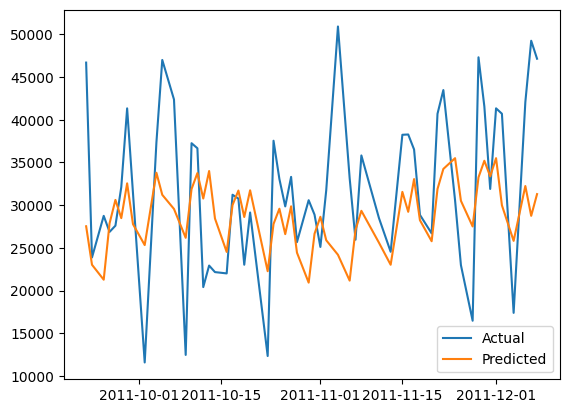

MAPE:  0.24606340005016902


In [16]:
m = Prophet(growth='linear', daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='multiplicative',
            changepoint_prior_scale=best_param['change_prior_scale'], seasonality_prior_scale=best_param['seasonality_prior_scale'], holidays_prior_scale=best_param['holidays_prior_scale'],
            changepoint_range=best_param['changepoint_range'], interval_width=best_param['interval_width'], uncertainty_samples=best_param['uncertainty_samples']
            )
m.add_country_holidays(country_name='UK')
m.fit(training_x)
future = testing_x[['ds']]
forecast = m.predict(future)
plt.plot(testing_x['ds'], testing_x['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted')
plt.legend()
plt.show()
print("MAPE: ", mean_absolute_percentage_error(testing_x['y'], forecast['yhat']))

MAPE test1:  0.3118362906228815
MAPE test2:  0.19802419074707803
MAPE test3:  0.22921640284402875


/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebre

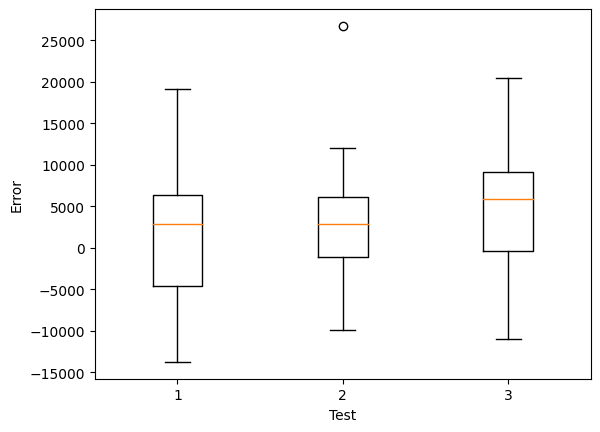

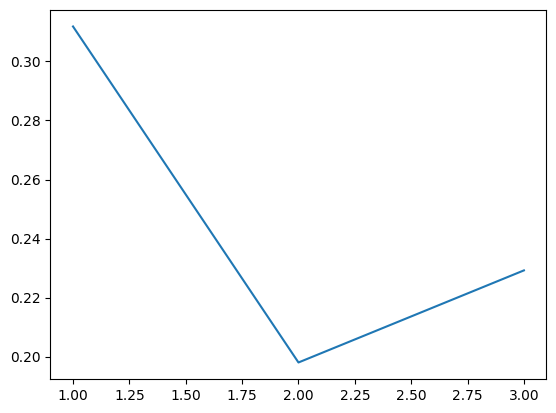

In [17]:
# split testing data into three parts
test1 = testing_x.iloc[:int(len(testing_x)/3)].reset_index(drop=True)
test2 = testing_x.iloc[int(len(testing_x)/3):int(len(testing_x)*2/3)].reset_index(drop=True)
test3 = testing_x.iloc[int(len(testing_x)*2/3):].reset_index(drop=True)
mape_test = []
err = pd.DataFrame(columns=['test1','test2','test3'])
forecast1 = m.predict(test1[['ds']])
err['test1'] = test1['y'] - forecast1['yhat']
mape_test.append(mean_absolute_percentage_error(test1['y'], forecast1['yhat']))
print("MAPE test1: ", mean_absolute_percentage_error(test1['y'], forecast1['yhat']))

forecast2 = m.predict(test2[['ds']])
err['test2'] = test2['y'] - forecast2['yhat']
mape_test.append(mean_absolute_percentage_error(test2['y'], forecast2['yhat']))
print("MAPE test2: ", mean_absolute_percentage_error(test2['y'], forecast2['yhat']))

forecast3 = m.predict(test3[['ds']])
err['test3'] = test3['y'] - forecast3['yhat']
mape_test.append(mean_absolute_percentage_error(test3['y'], forecast3['yhat']))
print("MAPE test3: ", mean_absolute_percentage_error(test3['y'], forecast3['yhat']))

plt.boxplot(err)
plt.xlabel('Test')
plt.ylabel('Error')
plt.show()

plt.plot([1,2,3],mape_test)

/opt/homebrew/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/lib/python3.9/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabe

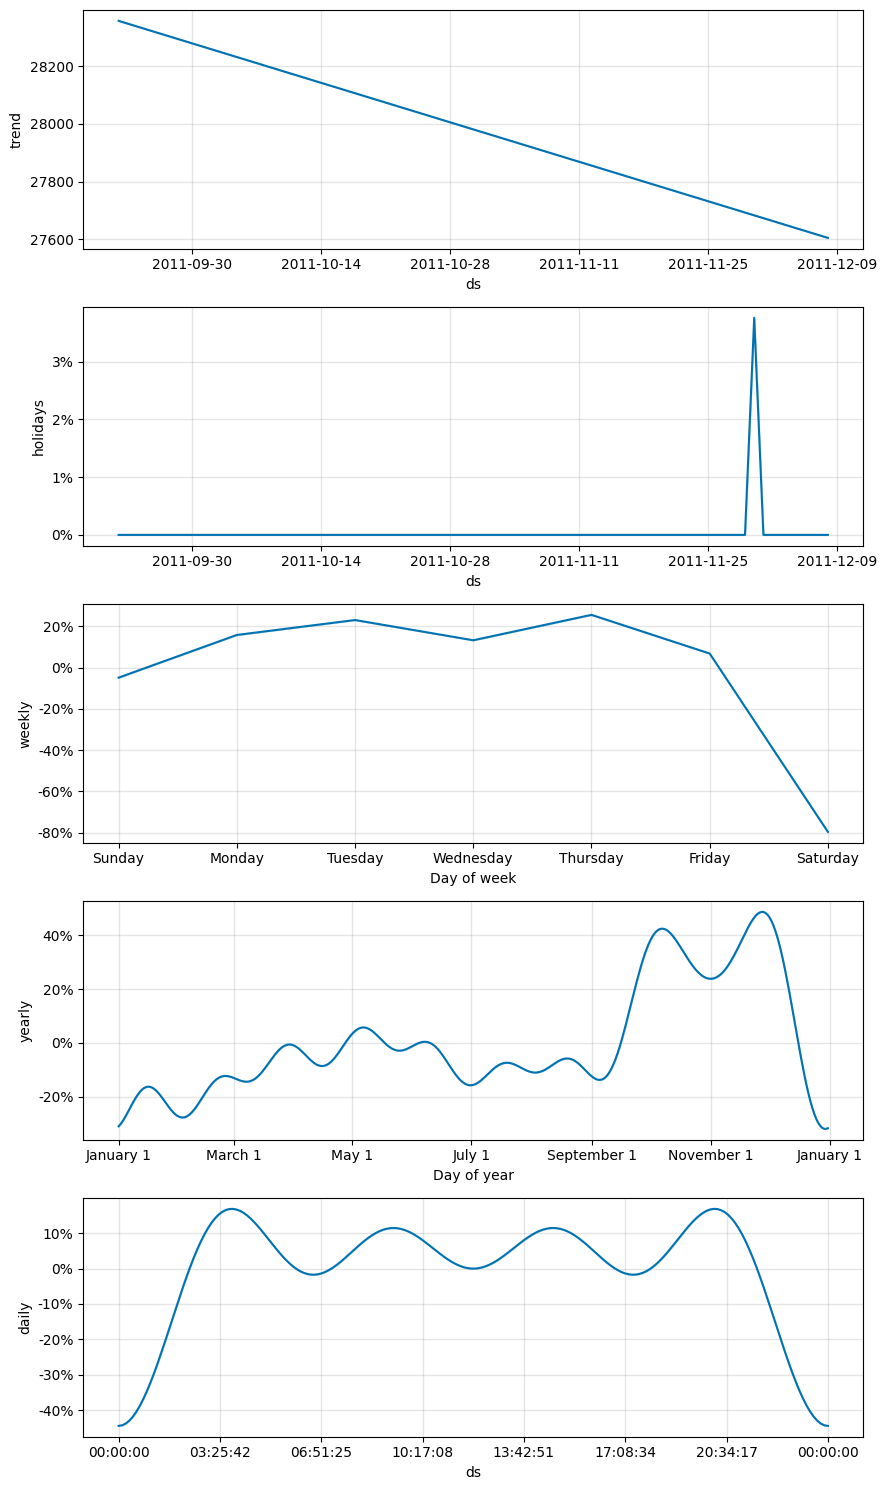

In [18]:
fig = m.plot_components(forecast)


In [19]:
import pickle
with open('../Models/prophet.pkl', 'wb') as f:
    pickle.dump(m, f)